In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

file_path = "F:\\Python\\PPG\\All data\\Patient_Signal\\PPG.csv"
data = pd.read_csv(file_path, header=None)

data.columns = ['Name', 'i', 'Bad', 'hands', 'label', 'systolic peak', 'Diastolic peak', 'Cardiac cycle', 'Cycle Area', 'SSI', 'Peak to Valley', 'Systolic peak y', 'Delta_T', '1st Derivative cycle', '1st Derivative peak', 'Ratio_BA', 'Ratio_CA', 'Ratio_DA', 'Ratio_BDCE_A', 'Ratio_CDB_A']
# Display the first few rows of the dataframe to understand its structure
data.head()

,Name,i,Bad,hands,label,systolic peak,Diastolic peak,Cardiac cycle,Cycle Area,SSI,Peak to Valley,Systolic peak y,Delta_T,1st Derivative cycle,1st Derivative peak,Ratio_BA,Ratio_CA,Ratio_DA,Ratio_BDCE_A,Ratio_CDB_A
0,伍黃秀霞,1,Right,Left,1,1278.0,0.390019,993.0,315.004855,987.0,720.0,0.516570,-1277.609981,1000.0,0.447513,1.022991,1.029483,1.047664,-2.109080,1.022221
1,伍黃秀霞,1,Right,Right,1,1265.0,0.275706,977.0,267.261331,995.0,714.0,0.485722,-1264.724294,994.0,0.327676,0.999176,0.997674,0.993834,-1.982910,1.000930
2,伍黃秀霞,3,Right,Left,1,1280.0,0.344179,997.0,307.701319,1011.0,718.0,0.468073,-1279.655821,994.0,0.427002,1.027341,1.050224,1.074771,-2.195227,1.027423
3,伍黃秀霞,3,Right,Right,1,1278.0,0.350065,979.0,286.925793,1011.0,705.0,0.506998,-1277.649935,1005.0,0.343972,0.991613,0.974413,0.961078,-1.887815,0.991555
4,伍黃秀霞,5,Right,Left,1,1296.0,0.354134,1000.0,318.004937,1009.0,701.0,0.428415,-1295.645866,996.0,0.360314,1.029600,1.045462,1.071122,-2.174579,1.028988


In [2]:
info_columns = data[['Name', 'i', 'Bad', 'hands']]
X = data.iloc[:, 5:]  # 特徵列
y = data['label']     # 標籤
#印出x的標題
print(X.columns)

# 分割訓練和測試集
X_train, X_test, y_train, y_test, info_train, info_test = train_test_split(X, y, info_columns, test_size=0.3, random_state=42)

# 特徵標準化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Index(['systolic peak', 'Diastolic peak', 'Cardiac cycle', 'Cycle Area', 'SSI',
       'Peak to Valley', 'Systolic peak y', 'Delta_T', '1st Derivative cycle',
       '1st Derivative peak', 'Ratio_BA', 'Ratio_CA', 'Ratio_DA',
       'Ratio_BDCE_A', 'Ratio_CDB_A'],
      dtype='object')


In [3]:
# 繪製混淆矩陣
def plot_confusion_matrix(conf_matrix, title='Confusion Matrix'):
    plt.figure(figsize=(5, 5), dpi=120)
    plt.imshow(conf_matrix, cmap='summer')
    plt.colorbar()

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, str(conf_matrix[i, j]), fontsize=12,
                     horizontalalignment='center', verticalalignment='center')

    plt.xticks(np.arange(0, 2), ['Predicted 0', 'Predicted 1'])
    plt.yticks(np.arange(0, 2), ['Actual 0', 'Actual 1'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.show()

In [4]:
# 計算性能指標
def calculate_metrics(conf_matrix):
    tp = conf_matrix[0, 0]
    fn = conf_matrix[0, 1]
    fp = conf_matrix[1, 0]
    tn = conf_matrix[1, 1]
    accuracy = (tp + tn) / (tp + fn + fp + tn) if (tp + fn + fp + tn) != 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) != 0 else 0

    metrics = {
        "Accuracy": round(accuracy,3),
        "Sensitivity (Recall)": round(sensitivity,3),
        "Specificity": round(specificity,3),
        "Precision": round(precision,3),
        "F1-Score": round(f1_score,3)
    }
    return metrics

In [ ]:
# 儲存結果到 CSV
def save_results_to_csv(filename, info, y_test, y_pred, Best_metrics, times):
    new_data = pd.DataFrame({
        'Name': info['Name'].values,
        'Cycle': info['i'].values,
        'Hands': info['hands'].values,
        'Actual_Label': y_test.values,
        'Predicted_Label': y_pred
    })

    new_data = new_data.sort_values(by='Name')
    new_data['Is_Correct'] = new_data['Actual_Label'] == new_data['Predicted_Label']

    # 將最終的 Actual_Label 和 Predicted_Label 的總結結果保存
    final_summary = new_data.groupby('Name').agg(
    Actual_0_Count=('Actual_Label', lambda x: (x == 0).sum()),
    Actual_1_Count=('Actual_Label', lambda x: (x == 1).sum()),
    Predicted_0_Count=('Predicted_Label', lambda x: (x == 0).sum()),
    Predicted_1_Count=('Predicted_Label', lambda x: (x == 1).sum())
    ).reset_index()

    # 判斷總體的預測結果
    final_summary['Predicted_Label'] = final_summary.apply(lambda row: 0 if row['Predicted_0_Count'] > row['Predicted_1_Count'] else 1, axis=1)
    final_summary['Actual_Label'] = final_summary.apply(lambda row: 0 if row['Actual_0_Count'] > row['Actual_1_Count'] else 1, axis=1)


    conf_matrix = confusion_matrix(final_summary['Actual_Label'], final_summary['Predicted_Label'])
    plot_confusion_matrix(conf_matrix, title='Final Confusion Matrix')
    Final_metrics = calculate_metrics(conf_matrix)
    print("Final Metrics:", Final_metrics)

    if Final_metrics['Accuracy'] > Best_metrics['Accuracy']:
        times = 0
        print(f"Accuracy improved from {Best_metrics['Accuracy']} to {Final_metrics['Accuracy']}.")
        Best_metrics = Final_metrics
        # 保存總結至 CSV
        new_data.to_csv(f"F:\\Python\\PPG\\All data\\Patient_Signal\\Exhaustive Search\\{filename}.csv", index=False, encoding='utf-8-sig')
        print(f"Results saved to {filename}.csv")
        final_summary.to_csv(f"F:\\Python\\PPG\\All data\\Patient_Signal\\Exhaustive Search\\{filename}_Final.csv", index=False, encoding='utf-8-sig')
        print(f"Results saved to {filename}_Final.csv")
    elif times <= 10:
        times += 1
        print(f"最佳為:{Best_metrics['Accuracy']}，進行第 {times} 次優化。")
        
    else:
        print("進行五次都沒有顯著提升，停止優化。")
        print("最佳結果: ", Final_metrics)
        Final_metrics = {'Accuracy': 0, 'Sensitivity': 0, 'Specificity': 0, 'Precision': 0, 'F1-Score': 0}

    return Final_metrics, times

In [6]:
# 生成所有可能的特徵子集
def generate_feature_subsets(features):
    subsets = []
    for r in range(1, len(features) + 1):
        subsets.extend(combinations(features, r))
    return subsets

# 評估特徵子集
def evaluate_feature_subsets(X, y, feature_subsets, model_train_function, info_train, info_test):
    best_subset = None
    best_metrics = None
    best_conf_matrix = None
    best_y_pred = None
    best_model = None

    results = []

    for subset in feature_subsets:
        subset_columns = list(subset)
        print(f"Evaluating subset: {subset_columns}")
        X_train_subset = X_train[:, [X.columns.get_loc(col) for col in subset_columns]]
        X_test_subset = X_test[:, [X.columns.get_loc(col) for col in subset_columns]]

        # 使用指定模型訓練函式進行訓練與測試
        model, metrics, conf_matrix, y_pred, *_ = model_train_function(
            X_train_subset, y_train, X_test_subset, y_test, subset_columns
        )

        # 記錄結果
        results.append((subset_columns, metrics))

        # 更新最佳子集
        if not best_metrics or metrics['F1-Score'] > best_metrics['F1-Score']:
            best_subset = subset_columns
            best_metrics = metrics
            best_conf_matrix = conf_matrix
            best_y_pred = y_pred
            best_model = model

    # 保存所有結果
    result_df = pd.DataFrame(results, columns=['Feature Subset', 'Metrics'])
    result_df.to_csv("F:\\All data\\Patient_Signal\\Classfication\\Feature_Subset_Evaluation.csv", index=False)

    return best_subset, best_metrics, best_conf_matrix, best_y_pred, best_model

feature_subsets = generate_feature_subsets(X.columns)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
最佳參數: {'C': 100, 'class_weight': 'balanced', 'kernel': 'rbf'}
特徵重要性排序：
                  Feature  Importance
11              Ratio_CA    0.117884
10              Ratio_BA    0.108170
1         Diastolic peak    0.107592
5         Peak to Valley    0.090600
14           Ratio_CDB_A    0.088999
13          Ratio_BDCE_A    0.065412
9    1st Derivative peak    0.060082
12              Ratio_DA    0.056168
3             Cycle Area    0.048338
7                Delta_T    0.043874
0          systolic peak    0.043755
4                    SSI    0.029711
8   1st Derivative cycle    0.019825
2          Cardiac cycle    0.017374
6        Systolic peak y    0.009416


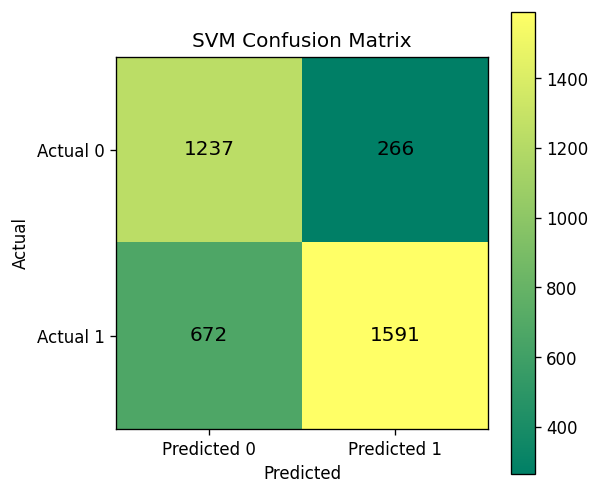

SVM Metrics: {'Accuracy': 0.751, 'Sensitivity (Recall)': 0.823, 'Specificity': 0.703, 'Precision': 0.648, 'F1-Score': 0.725}


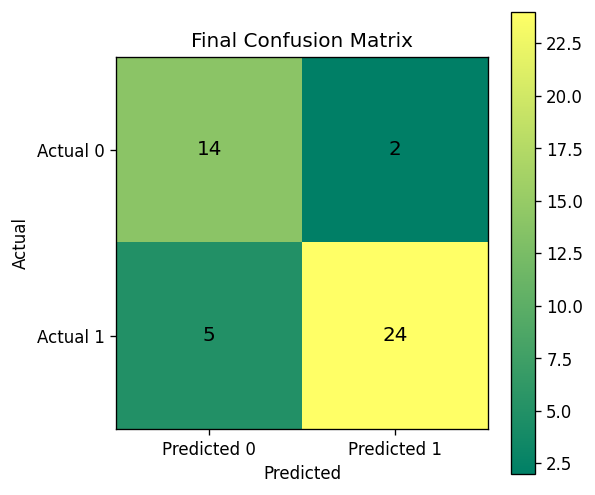

Final Metrics: {'Accuracy': 0.844, 'Sensitivity (Recall)': 0.875, 'Specificity': 0.828, 'Precision': 0.737, 'F1-Score': 0.8}
Accuracy improved from 0 to 0.844.
Results saved to SVM_Results.csv
Results saved to SVM_Results_Final.csv


In [ ]:
def train_svm(X_train, y_train, X_test, y_test, X_columns):
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'class_weight': ['balanced']
    }

    svm_grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    svm_grid_search.fit(X_train, y_train)

    best_model = svm_grid_search.best_estimator_
    best_params = svm_grid_search.best_params_
    y_pred = best_model.predict(X_test)
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    metrics = calculate_metrics(conf_matrix)

    # 如果使用線性核，可以直接通過 coef_ 計算特徵重要性
    if best_params['kernel'] == 'linear':
        feature_importance = np.abs(best_model.coef_[0])
        feature_importance_df = pd.DataFrame({
            'Feature': X_columns,
            'Importance': feature_importance
        }).sort_values(by='Importance', ascending=False)
    else:
        # 如果使用非線性核，則使用置換特徵重要性來估算
        results = permutation_importance(best_model, X_test, y_test, n_repeats=100, random_state=42, n_jobs=-1)
        feature_importance = results.importances_mean  # 平均置換重要性得分
        feature_importance_df = pd.DataFrame({
            'Feature': X_columns,
            'Importance': feature_importance
        }).sort_values(by='Importance', ascending=False)

    # 預測測試集
    print("最佳參數:", best_params)
    print("特徵重要性排序：\n", feature_importance_df)

    return best_model, metrics, conf_matrix, y_pred, feature_importance_df


# SVM
Best_metrics = {'Accuracy': 0, 'Sensitivity': 0, 'Specificity': 0, 'Precision': 0, 'F1-Score': 0}
svm_model, svm_metrics, svm_conf_matrix, svm_y_pred, feature_importance_df = train_svm(X_train, y_train, X_test, y_test, X.columns)
plot_confusion_matrix(svm_conf_matrix, title='SVM Confusion Matrix')
print("SVM Metrics:", svm_metrics)
Best_metrics, times = save_results_to_csv('SVM_Results', info_test, y_test, svm_y_pred, Best_metrics, 0)

In [8]:
Modify_SVM_X = X
Modify_SVM_X_train = X_train
Modify_SVM_X_test = X_test
Modify_SVM_y_train = y_train
Modify_SVM_y_test = y_test
times = 0

Fitting 5 folds for each of 16 candidates, totalling 80 fits
最佳參數: {'C': 100, 'class_weight': 'balanced', 'kernel': 'rbf'}
特徵重要性排序：
                  Feature  Importance
10              Ratio_CA    0.124100
1         Diastolic peak    0.112926
9               Ratio_BA    0.106845
5         Peak to Valley    0.093736
13           Ratio_CDB_A    0.089814
12          Ratio_BDCE_A    0.064859
11              Ratio_DA    0.063664
8    1st Derivative peak    0.058755
3             Cycle Area    0.048314
6                Delta_T    0.047698
0          systolic peak    0.047496
4                    SSI    0.027252
2          Cardiac cycle    0.023176
7   1st Derivative cycle    0.021431


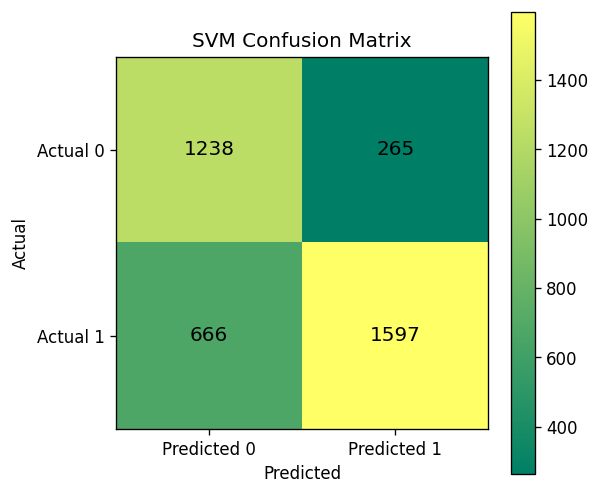

SVM Metrics: {'Accuracy': 0.753, 'Sensitivity (Recall)': 0.824, 'Specificity': 0.706, 'Precision': 0.65, 'F1-Score': 0.727}


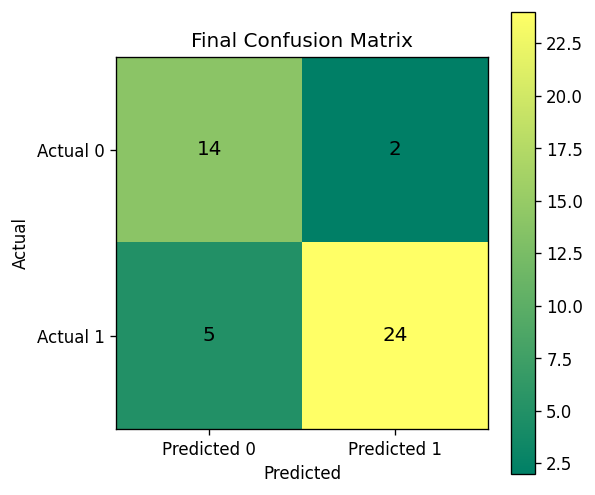

Final Metrics: {'Accuracy': 0.844, 'Sensitivity (Recall)': 0.875, 'Specificity': 0.828, 'Precision': 0.737, 'F1-Score': 0.8}
沒有優化，進行第 1 次優化。
Fitting 5 folds for each of 16 candidates, totalling 80 fits
最佳參數: {'C': 100, 'class_weight': 'balanced', 'kernel': 'rbf'}
特徵重要性排序：
                 Feature  Importance
9              Ratio_CA    0.128173
1        Diastolic peak    0.115340
8              Ratio_BA    0.109251
5        Peak to Valley    0.096235
12          Ratio_CDB_A    0.089689
11         Ratio_BDCE_A    0.068784
10             Ratio_DA    0.068425
7   1st Derivative peak    0.064291
3            Cycle Area    0.054655
6               Delta_T    0.054222
0         systolic peak    0.054158
4                   SSI    0.032576
2         Cardiac cycle    0.031309


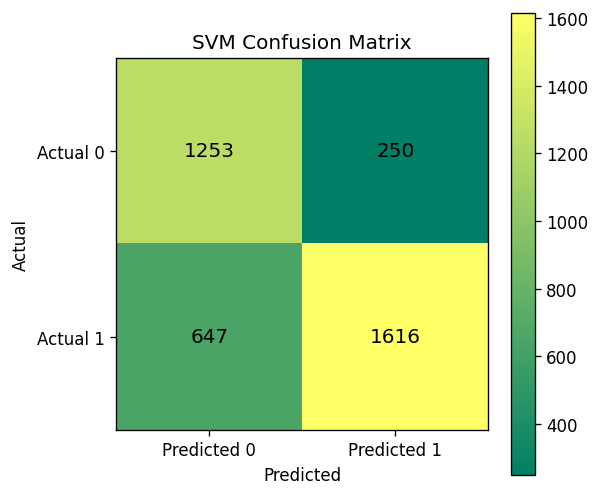

SVM Metrics: {'Accuracy': 0.762, 'Sensitivity (Recall)': 0.834, 'Specificity': 0.714, 'Precision': 0.659, 'F1-Score': 0.736}


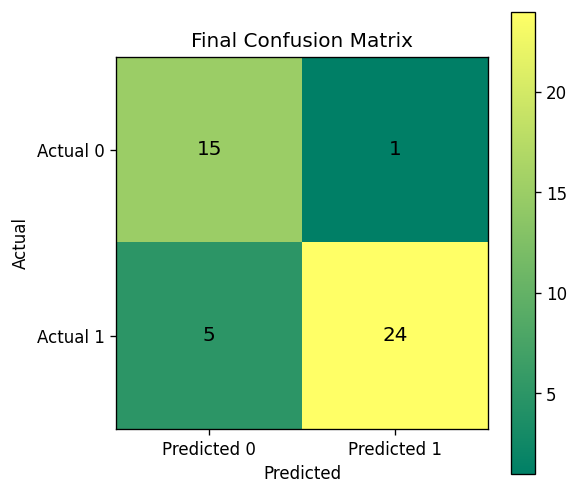

Final Metrics: {'Accuracy': 0.867, 'Sensitivity (Recall)': 0.938, 'Specificity': 0.828, 'Precision': 0.75, 'F1-Score': 0.833}
Accuracy improved from 0.844 to 0.867.
Results saved to SVM_Results.csv
Results saved to SVM_Results_Final.csv
Fitting 5 folds for each of 16 candidates, totalling 80 fits
最佳參數: {'C': 100, 'class_weight': 'balanced', 'kernel': 'rbf'}
特徵重要性排序：
                 Feature  Importance
8              Ratio_CA    0.132209
1        Diastolic peak    0.121405
7              Ratio_BA    0.114233
11          Ratio_CDB_A    0.105374
4        Peak to Valley    0.085629
6   1st Derivative peak    0.075645
10         Ratio_BDCE_A    0.070348
9              Ratio_DA    0.066981
2            Cycle Area    0.059881
5               Delta_T    0.054899
0         systolic peak    0.054825
3                   SSI    0.040640


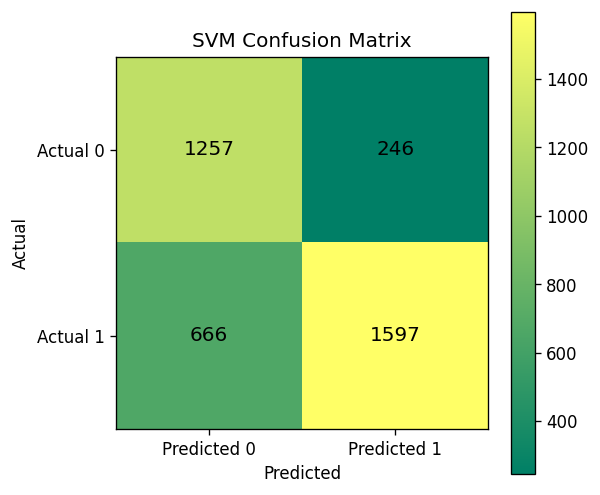

SVM Metrics: {'Accuracy': 0.758, 'Sensitivity (Recall)': 0.836, 'Specificity': 0.706, 'Precision': 0.654, 'F1-Score': 0.734}


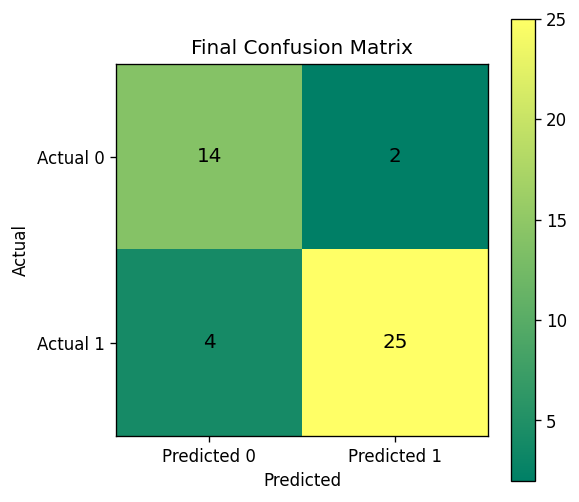

Final Metrics: {'Accuracy': 0.867, 'Sensitivity (Recall)': 0.875, 'Specificity': 0.862, 'Precision': 0.778, 'F1-Score': 0.824}
沒有優化，進行第 1 次優化。
Fitting 5 folds for each of 16 candidates, totalling 80 fits
最佳參數: {'C': 100, 'class_weight': 'balanced', 'kernel': 'rbf'}
特徵重要性排序：
                 Feature  Importance
10          Ratio_CDB_A    0.125032
7              Ratio_CA    0.114219
1        Diastolic peak    0.109987
6              Ratio_BA    0.098757
3        Peak to Valley    0.080866
9          Ratio_BDCE_A    0.065133
5   1st Derivative peak    0.063508
2            Cycle Area    0.054426
8              Ratio_DA    0.048999
4               Delta_T    0.044533
0         systolic peak    0.044371


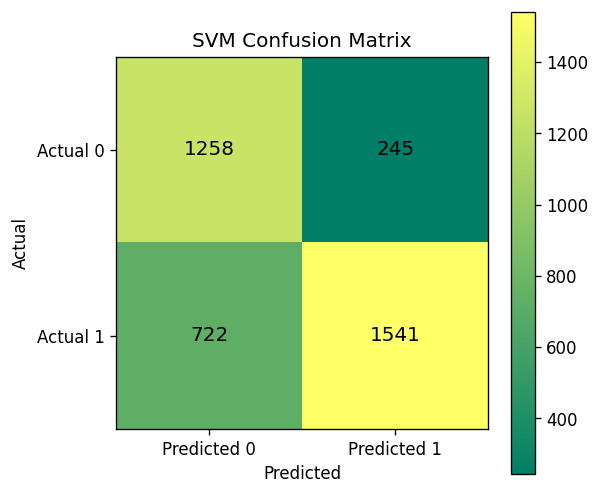

SVM Metrics: {'Accuracy': 0.743, 'Sensitivity (Recall)': 0.837, 'Specificity': 0.681, 'Precision': 0.635, 'F1-Score': 0.722}


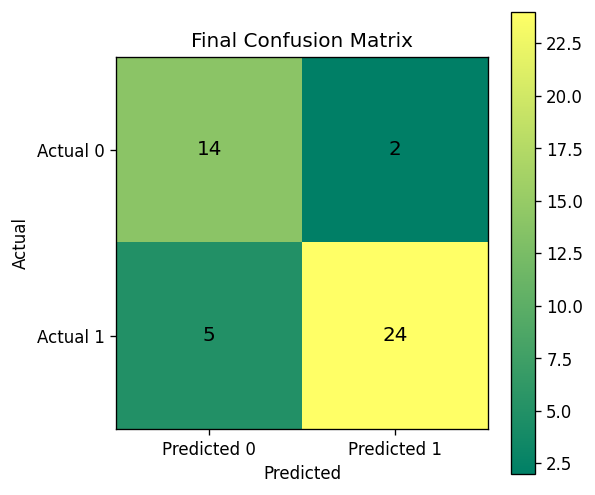

Final Metrics: {'Accuracy': 0.844, 'Sensitivity (Recall)': 0.875, 'Specificity': 0.828, 'Precision': 0.737, 'F1-Score': 0.8}
沒有優化，進行第 2 次優化。
Fitting 5 folds for each of 16 candidates, totalling 80 fits
最佳參數: {'C': 100, 'class_weight': 'balanced', 'kernel': 'rbf'}
特徵重要性排序：
                Feature  Importance
0       Diastolic peak    0.118372
9          Ratio_CDB_A    0.118301
6             Ratio_CA    0.116691
5             Ratio_BA    0.103635
3              Delta_T    0.092889
2       Peak to Valley    0.087870
4  1st Derivative peak    0.067406
8         Ratio_BDCE_A    0.063001
1           Cycle Area    0.054217
7             Ratio_DA    0.048266


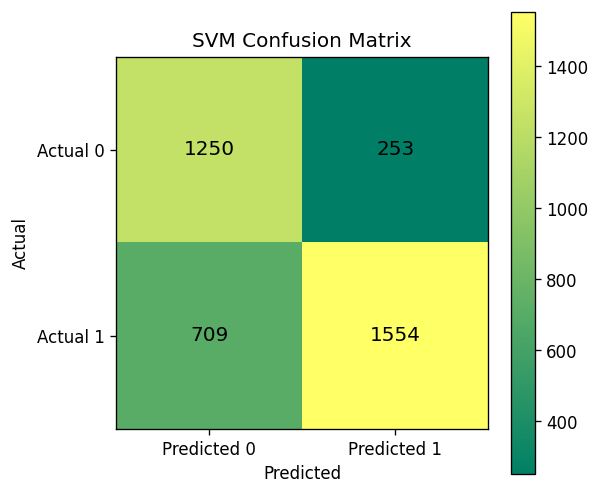

SVM Metrics: {'Accuracy': 0.745, 'Sensitivity (Recall)': 0.832, 'Specificity': 0.687, 'Precision': 0.638, 'F1-Score': 0.722}


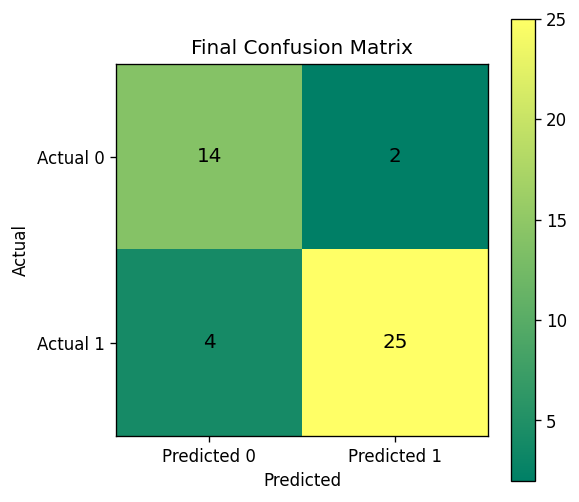

Final Metrics: {'Accuracy': 0.867, 'Sensitivity (Recall)': 0.875, 'Specificity': 0.862, 'Precision': 0.778, 'F1-Score': 0.824}
Accuracy improved from 0.844 to 0.867.
Results saved to SVM_Results.csv
Results saved to SVM_Results_Final.csv
Fitting 5 folds for each of 16 candidates, totalling 80 fits
最佳參數: {'C': 100, 'class_weight': 'balanced', 'kernel': 'rbf'}
特徵重要性排序：
                Feature  Importance
6             Ratio_CA    0.126811
8          Ratio_CDB_A    0.122124
0       Diastolic peak    0.121341
2       Peak to Valley    0.094918
5             Ratio_BA    0.094108
3              Delta_T    0.092485
7         Ratio_BDCE_A    0.074063
4  1st Derivative peak    0.068008
1           Cycle Area    0.056715


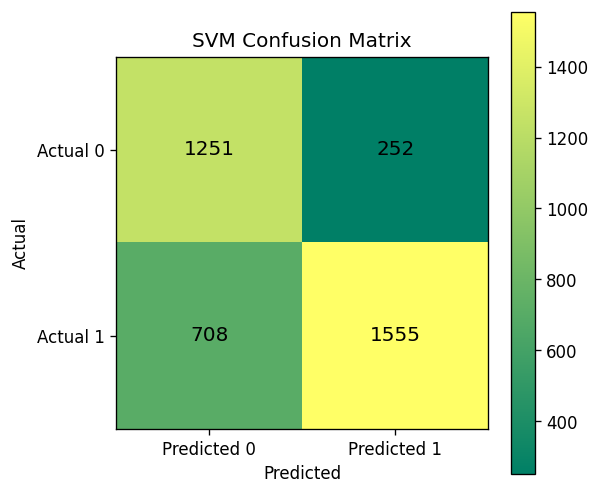

SVM Metrics: {'Accuracy': 0.745, 'Sensitivity (Recall)': 0.832, 'Specificity': 0.687, 'Precision': 0.639, 'F1-Score': 0.723}


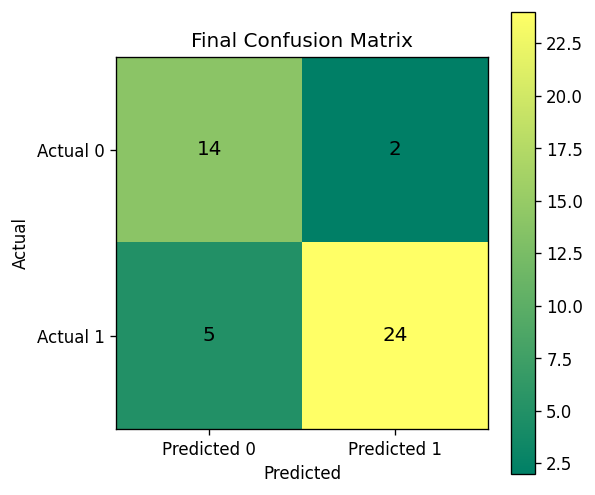

Final Metrics: {'Accuracy': 0.844, 'Sensitivity (Recall)': 0.875, 'Specificity': 0.828, 'Precision': 0.737, 'F1-Score': 0.8}
沒有優化，進行第 1 次優化。
Fitting 5 folds for each of 16 candidates, totalling 80 fits
最佳參數: {'C': 100, 'class_weight': 'balanced', 'kernel': 'rbf'}
特徵重要性排序：
                Feature  Importance
5             Ratio_CA    0.111290
7          Ratio_CDB_A    0.110080
0       Diastolic peak    0.110077
4             Ratio_BA    0.085165
6         Ratio_BDCE_A    0.079264
2              Delta_T    0.077257
1       Peak to Valley    0.072127
3  1st Derivative peak    0.060871


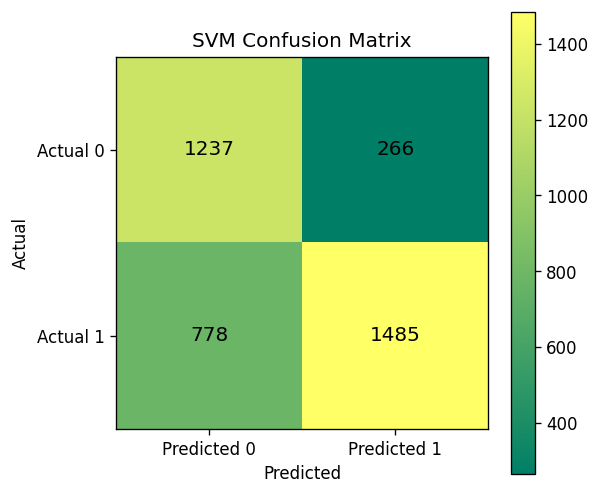

SVM Metrics: {'Accuracy': 0.723, 'Sensitivity (Recall)': 0.823, 'Specificity': 0.656, 'Precision': 0.614, 'F1-Score': 0.703}


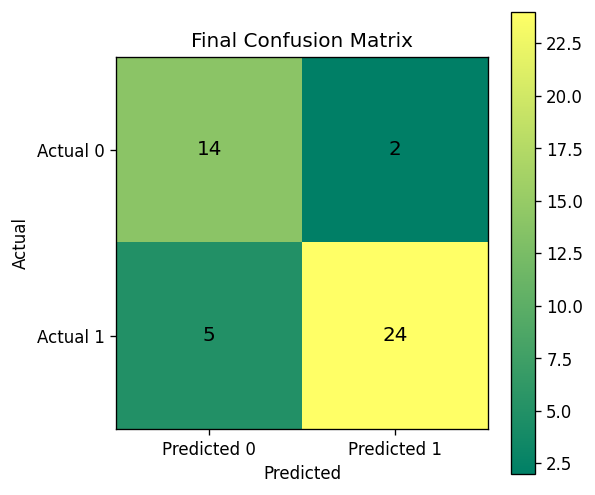

Final Metrics: {'Accuracy': 0.844, 'Sensitivity (Recall)': 0.875, 'Specificity': 0.828, 'Precision': 0.737, 'F1-Score': 0.8}
沒有優化，進行第 2 次優化。
Fitting 5 folds for each of 16 candidates, totalling 80 fits
最佳參數: {'C': 100, 'class_weight': 'balanced', 'kernel': 'rbf'}
特徵重要性排序：
           Feature  Importance
0  Diastolic peak    0.107191
6     Ratio_CDB_A    0.105194
4        Ratio_CA    0.080255
1  Peak to Valley    0.078834
5    Ratio_BDCE_A    0.076768
3        Ratio_BA    0.074368
2         Delta_T    0.074073


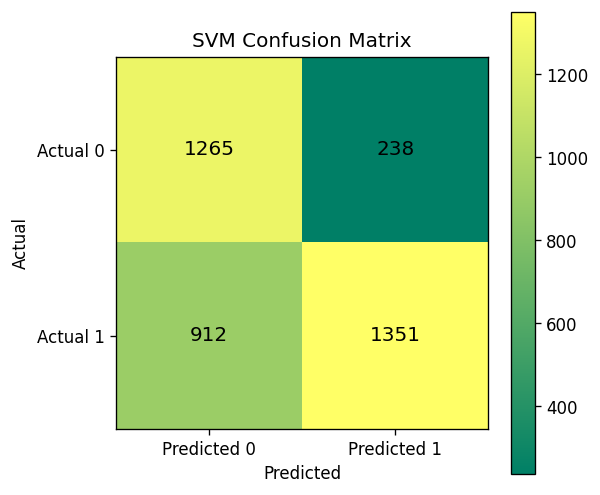

SVM Metrics: {'Accuracy': 0.695, 'Sensitivity (Recall)': 0.842, 'Specificity': 0.597, 'Precision': 0.581, 'F1-Score': 0.688}


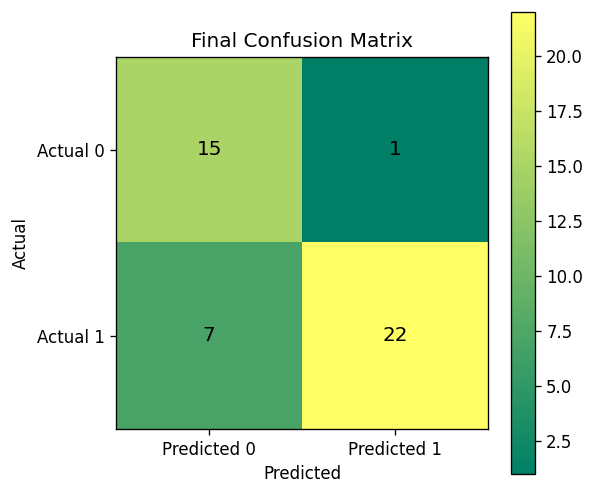

Final Metrics: {'Accuracy': 0.822, 'Sensitivity (Recall)': 0.938, 'Specificity': 0.759, 'Precision': 0.682, 'F1-Score': 0.789}
沒有優化，進行第 3 次優化。
Fitting 5 folds for each of 16 candidates, totalling 80 fits
最佳參數: {'C': 100, 'class_weight': 'balanced', 'kernel': 'rbf'}
特徵重要性排序：
           Feature  Importance
0  Diastolic peak    0.102517
5     Ratio_CDB_A    0.092209
2        Ratio_BA    0.079841
3        Ratio_CA    0.069195
1  Peak to Valley    0.062677
4    Ratio_BDCE_A    0.062310


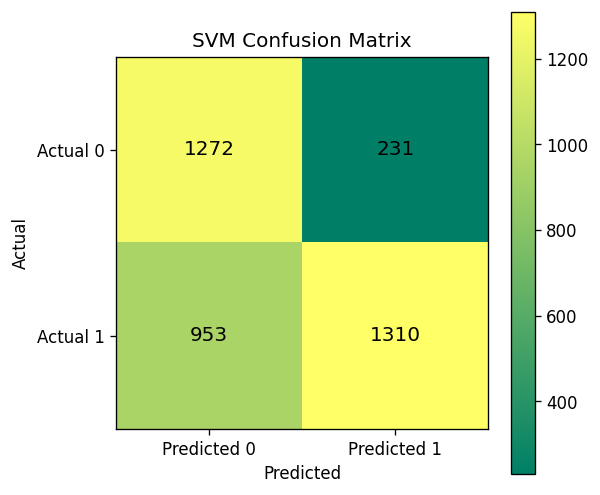

SVM Metrics: {'Accuracy': 0.686, 'Sensitivity (Recall)': 0.846, 'Specificity': 0.579, 'Precision': 0.572, 'F1-Score': 0.682}


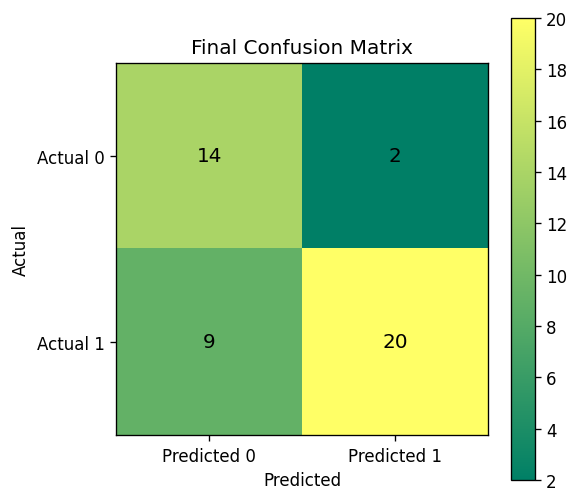

Final Metrics: {'Accuracy': 0.756, 'Sensitivity (Recall)': 0.875, 'Specificity': 0.69, 'Precision': 0.609, 'F1-Score': 0.718}
沒有優化，進行第 4 次優化。
Fitting 5 folds for each of 16 candidates, totalling 80 fits
最佳參數: {'C': 100, 'class_weight': 'balanced', 'kernel': 'rbf'}
特徵重要性排序：
           Feature  Importance
4     Ratio_CDB_A    0.109604
0  Diastolic peak    0.107331
2        Ratio_BA    0.087576
3        Ratio_CA    0.064899
1  Peak to Valley    0.061827


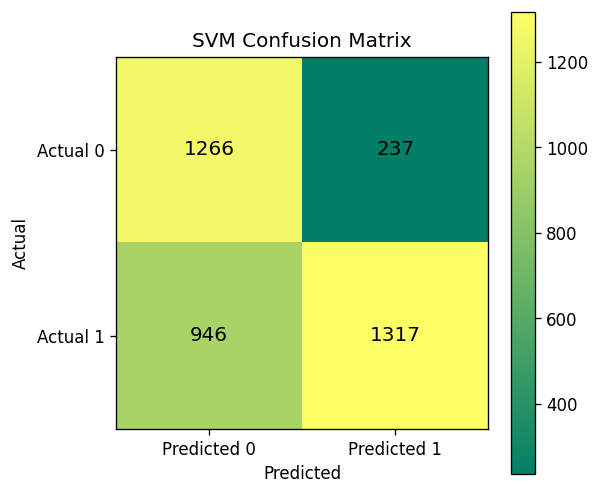

SVM Metrics: {'Accuracy': 0.686, 'Sensitivity (Recall)': 0.842, 'Specificity': 0.582, 'Precision': 0.572, 'F1-Score': 0.682}


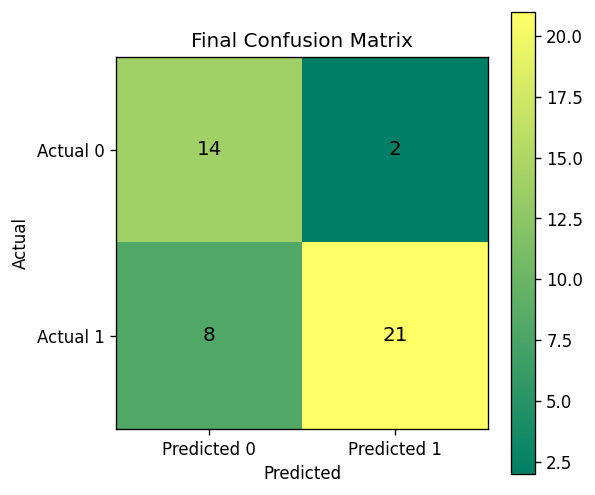

Final Metrics: {'Accuracy': 0.778, 'Sensitivity (Recall)': 0.875, 'Specificity': 0.724, 'Precision': 0.636, 'F1-Score': 0.737}
Accuracy improved from 0.756 to 0.778.
Results saved to SVM_Results.csv
Results saved to SVM_Results_Final.csv
Fitting 5 folds for each of 16 candidates, totalling 80 fits
最佳參數: {'C': 100, 'class_weight': 'balanced', 'kernel': 'rbf'}
特徵重要性排序：
           Feature  Importance
3     Ratio_CDB_A    0.109041
1        Ratio_BA    0.102114
0  Diastolic peak    0.092074
2        Ratio_CA    0.048959


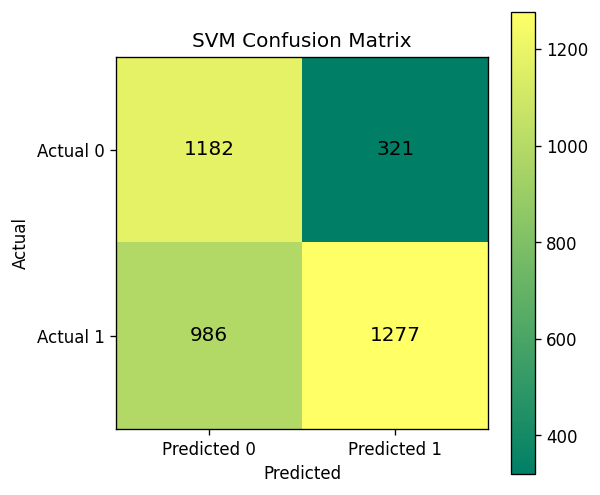

SVM Metrics: {'Accuracy': 0.653, 'Sensitivity (Recall)': 0.786, 'Specificity': 0.564, 'Precision': 0.545, 'F1-Score': 0.644}


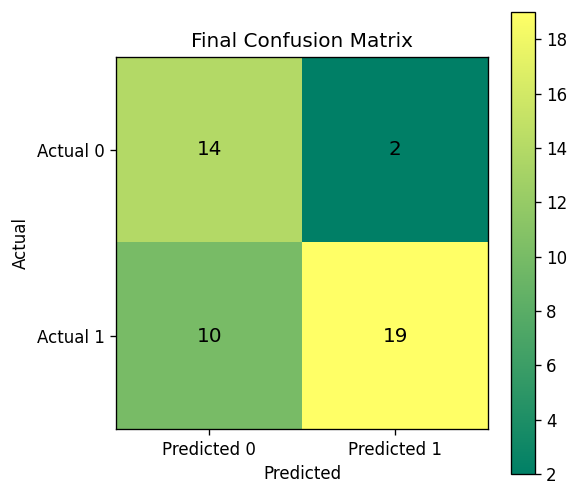

Final Metrics: {'Accuracy': 0.733, 'Sensitivity (Recall)': 0.875, 'Specificity': 0.655, 'Precision': 0.583, 'F1-Score': 0.7}
沒有優化，進行第 1 次優化。
Fitting 5 folds for each of 16 candidates, totalling 80 fits
最佳參數: {'C': 100, 'class_weight': 'balanced', 'kernel': 'rbf'}
特徵重要性排序：
           Feature  Importance
1        Ratio_BA    0.136954
2     Ratio_CDB_A    0.125669
0  Diastolic peak    0.100770


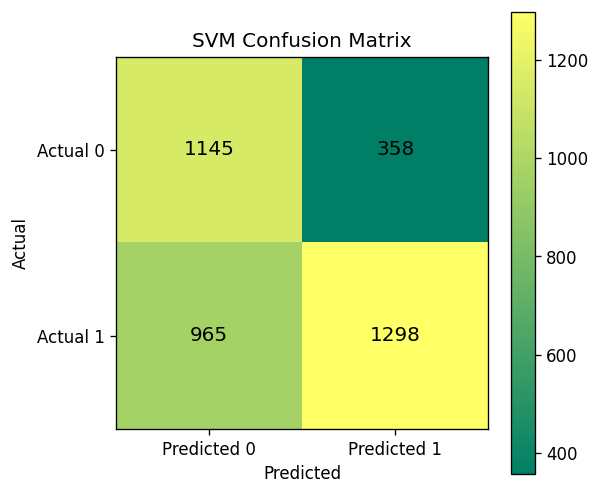

SVM Metrics: {'Accuracy': 0.649, 'Sensitivity (Recall)': 0.762, 'Specificity': 0.574, 'Precision': 0.543, 'F1-Score': 0.634}


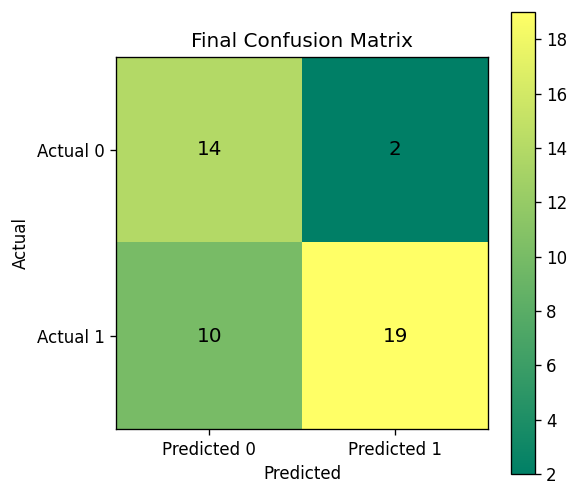

Final Metrics: {'Accuracy': 0.733, 'Sensitivity (Recall)': 0.875, 'Specificity': 0.655, 'Precision': 0.583, 'F1-Score': 0.7}
沒有優化，進行第 2 次優化。
Fitting 5 folds for each of 16 candidates, totalling 80 fits
最佳參數: {'C': 10, 'class_weight': 'balanced', 'kernel': 'poly'}
特徵重要性排序：
        Feature  Importance
0     Ratio_BA    0.002257
1  Ratio_CDB_A    0.001012


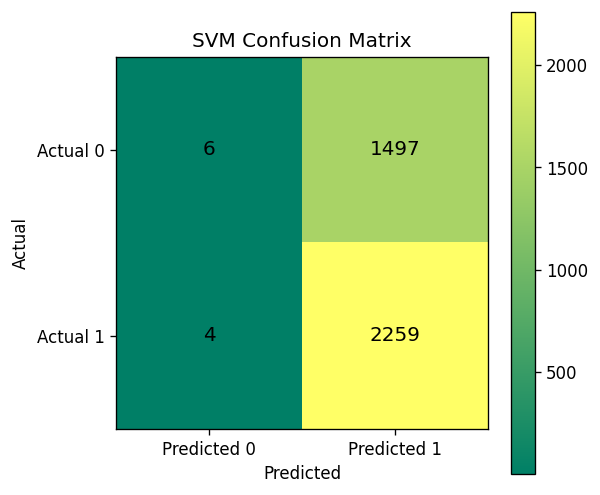

SVM Metrics: {'Accuracy': 0.601, 'Sensitivity (Recall)': 0.004, 'Specificity': 0.998, 'Precision': 0.6, 'F1-Score': 0.008}


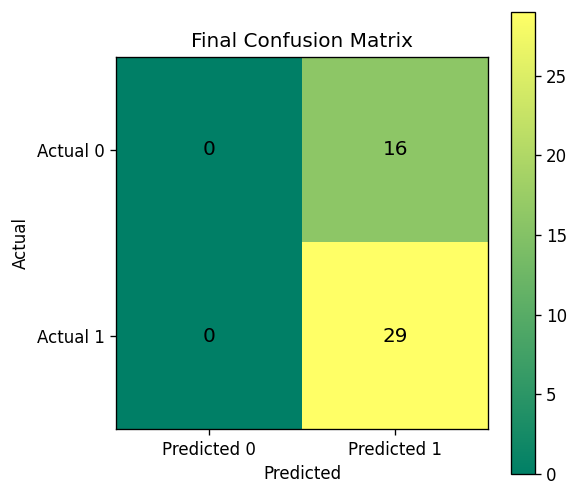

Final Metrics: {'Accuracy': 0.644, 'Sensitivity (Recall)': 0.0, 'Specificity': 1.0, 'Precision': 0, 'F1-Score': 0}
沒有優化，進行第 3 次優化。
Fitting 5 folds for each of 16 candidates, totalling 80 fits
最佳參數: {'C': 100, 'class_weight': 'balanced', 'kernel': 'poly'}
特徵重要性排序：
     Feature  Importance
0  Ratio_BA    0.001052


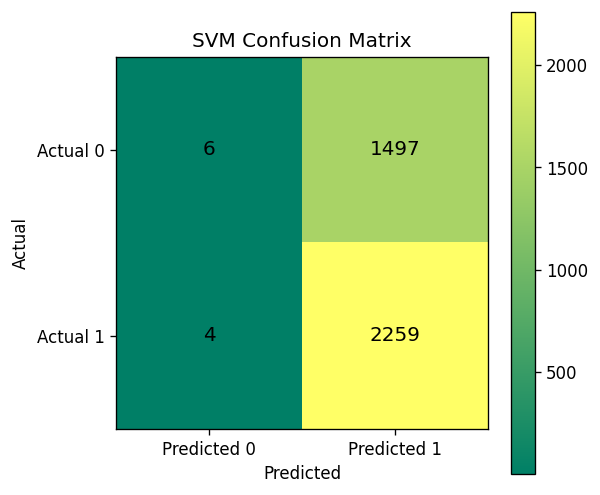

SVM Metrics: {'Accuracy': 0.601, 'Sensitivity (Recall)': 0.004, 'Specificity': 0.998, 'Precision': 0.6, 'F1-Score': 0.008}


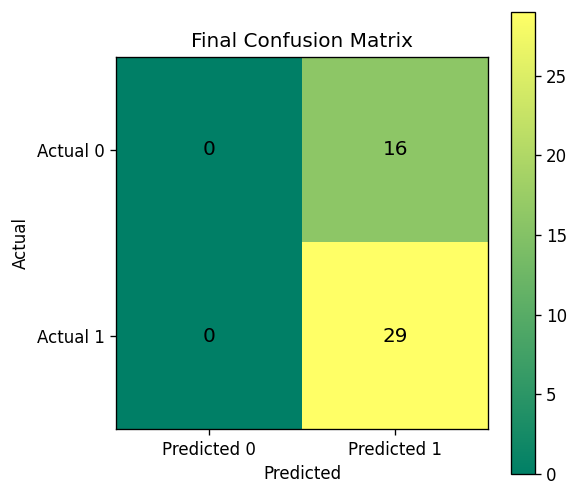

Final Metrics: {'Accuracy': 0.644, 'Sensitivity (Recall)': 0.0, 'Specificity': 1.0, 'Precision': 0, 'F1-Score': 0}
沒有優化，進行第 4 次優化。
Fitting 5 folds for each of 16 candidates, totalling 80 fits


ValueError: 
All the 80 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
32 fits failed with the following error:
Traceback (most recent call last):
  File "e:\miniconda\envs\ppg\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "e:\miniconda\envs\ppg\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\miniconda\envs\ppg\Lib\site-packages\sklearn\svm\_base.py", line 190, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "e:\miniconda\envs\ppg\Lib\site-packages\sklearn\base.py", line 622, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\miniconda\envs\ppg\Lib\site-packages\sklearn\utils\validation.py", line 1146, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "e:\miniconda\envs\ppg\Lib\site-packages\sklearn\utils\validation.py", line 976, in check_array
    raise ValueError(
ValueError: Found array with 0 feature(s) (shape=(7029, 0)) while a minimum of 1 is required by SVC.

--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "e:\miniconda\envs\ppg\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "e:\miniconda\envs\ppg\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\miniconda\envs\ppg\Lib\site-packages\sklearn\svm\_base.py", line 190, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "e:\miniconda\envs\ppg\Lib\site-packages\sklearn\base.py", line 622, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\miniconda\envs\ppg\Lib\site-packages\sklearn\utils\validation.py", line 1146, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "e:\miniconda\envs\ppg\Lib\site-packages\sklearn\utils\validation.py", line 976, in check_array
    raise ValueError(
ValueError: Found array with 0 feature(s) (shape=(7030, 0)) while a minimum of 1 is required by SVC.


In [9]:
while Best_metrics != {'Accuracy': 0, 'Sensitivity': 0, 'Specificity': 0, 'Precision': 0, 'F1-Score': 0}:
    
    # print(feature_importance_df['Feature'].values)
    # print(feature_importance_df['Feature'].values[-1])

    # 獲取要刪除的特徵
    Delete_Feature = feature_importance_df['Feature'].values[-1]
    Delete_Index = Modify_SVM_X.columns.get_loc(Delete_Feature)

    # 刪除特徵列
    Modify_SVM_X_train = np.delete(Modify_SVM_X_train, Delete_Index, axis=1)
    Modify_SVM_X_test = np.delete(Modify_SVM_X_test, Delete_Index, axis=1)

    # 更新 Modify_X，刪除對應的特徵列
    Modify_SVM_X = Modify_SVM_X.drop(Delete_Feature, axis=1)

    # 確保刪除後的特徵對應於最新的 Modify_X.columns
    svm_model, svm_metrics, svm_conf_matrix, svm_y_pred, feature_importance_df = train_svm(Modify_SVM_X_train, y_train, Modify_SVM_X_test, y_test, Modify_SVM_X.columns)

    # 顯示混淆矩陣
    plot_confusion_matrix(svm_conf_matrix, title='SVM Confusion Matrix')

    # 顯示 SVM 評估指標
    print("SVM Metrics:", svm_metrics)

    # 儲存結果並更新 Best_metrics
    Best_metrics, times = save_results_to_csv('SVM_Results', info_test, y_test, svm_y_pred, Best_metrics, times)


In [ ]:
info_columns = data[['Name', 'i', 'Bad', 'hands']]
X = data.iloc[:, 5:]  # 特徵列
y = data['label']     # 標籤
#印出x的標題
print(X.columns)

# 分割訓練和測試集
X_train, X_test, y_train, y_test, info_train, info_test = train_test_split(X, y, info_columns, test_size=0.3, random_state=42)

# 特徵標準化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Index(['systolic peak', 'Diastolic peak', 'Cardiac cycle', 'Cycle Area', 'SSI',
       'Peak to Valley', 'Systolic peak y', 'Delta_T', '1st Derivative cycle',
       '1st Derivative peak', 'Ratio_BA', 'Ratio_CA', 'Ratio_DA',
       'Ratio_BDCE_A', 'Ratio_CDB_A'],
      dtype='object')


Fitting 5 folds for each of 20 candidates, totalling 100 fits
最佳參數: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
特徵重要性排序：
                  Feature  Importance
1         Diastolic peak    0.086036
9    1st Derivative peak    0.029041
3             Cycle Area    0.022671
4                    SSI    0.014570
8   1st Derivative cycle    0.013494
14           Ratio_CDB_A    0.010802
10              Ratio_BA    0.009291
0          systolic peak    0.008051
7                Delta_T    0.007836
5         Peak to Valley    0.006341
6        Systolic peak y    0.005194
2          Cardiac cycle    0.003582
13          Ratio_BDCE_A    0.003019
12              Ratio_DA    0.002337
11              Ratio_CA    0.001782


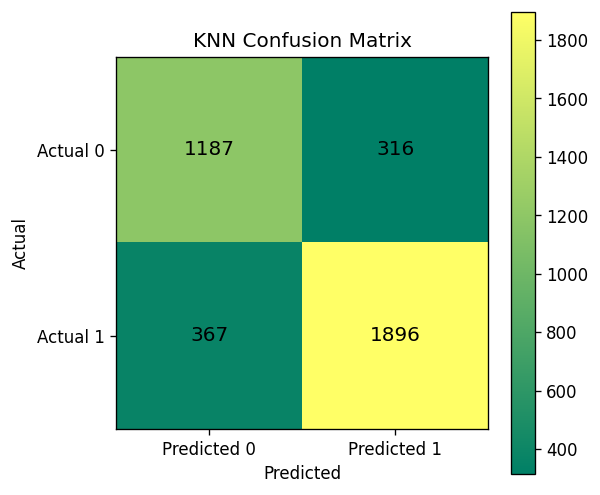

KNN Metrics: {'Accuracy': 0.819, 'Sensitivity (Recall)': 0.79, 'Specificity': 0.838, 'Precision': 0.764, 'F1-Score': 0.777}


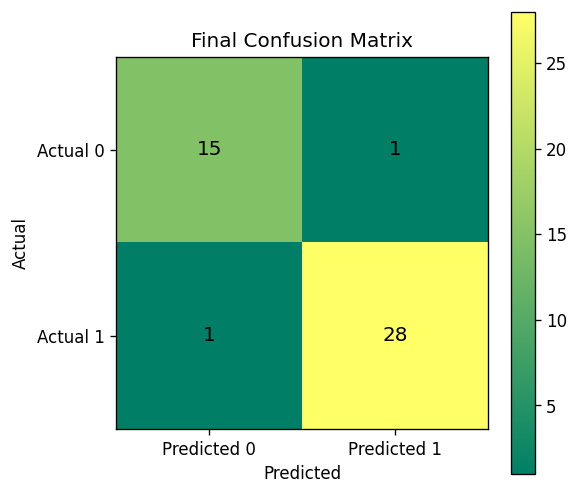

Final Metrics: {'Accuracy': 0.956, 'Sensitivity (Recall)': 0.938, 'Specificity': 0.966, 'Precision': 0.938, 'F1-Score': 0.938}
Accuracy improved from 0 to 0.956.
Results saved to KNN_Results.csv
Results saved to KNN_Results_Final.csv


In [ ]:
def train_knn(X_train, y_train, X_test, y_test, X_columns):
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }

    knn_grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    knn_grid_search.fit(X_train, y_train)

    best_model = knn_grid_search.best_estimator_
    best_params = knn_grid_search.best_params_
    y_pred = best_model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    metrics = calculate_metrics(conf_matrix)

    # 特徵重要性 - 基於置換的重要性
    results = permutation_importance(best_model, X_test, y_test, n_repeats=100, random_state=42, n_jobs=-1)
    feature_importance = results.importances_mean  # 平均置換重要性得分
    feature_importance_df = pd.DataFrame({
        'Feature': X_columns,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

    print("最佳參數:", best_params)
    print("特徵重要性排序：\n", feature_importance_df)

    return best_model, metrics, conf_matrix, y_pred, feature_importance_df

# KNN
Best_metrics = {'Accuracy': 0, 'Sensitivity': 0, 'Specificity': 0, 'Precision': 0, 'F1-Score': 0}
knn_model, knn_metrics, knn_conf_matrix, knn_y_pred, feature_importance_df = train_knn(X_train, y_train, X_test, y_test, X.columns)
plot_confusion_matrix(knn_conf_matrix, title='KNN Confusion Matrix')
print("KNN Metrics:", knn_metrics)
Best_metrics, times = save_results_to_csv('KNN_Results', info_test, y_test, knn_y_pred, Best_metrics, times)


In [ ]:
Modify_KNN_X = X
Modify_KNN_X_train = X_train
Modify_KNN_X_test = X_test
Modify_KNN_y_train = y_train
Modify_KNN_y_test = y_test

['Diastolic peak' '1st Derivative peak' 'Cycle Area' 'SSI'
 '1st Derivative cycle' 'Ratio_CDB_A' 'Ratio_BA' 'systolic peak' 'Delta_T'
 'Peak to Valley' 'Systolic peak y' 'Cardiac cycle' 'Ratio_BDCE_A'
 'Ratio_DA' 'Ratio_CA']
Ratio_CA
Fitting 5 folds for each of 20 candidates, totalling 100 fits
最佳參數: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
特徵重要性排序：
                  Feature  Importance
1         Diastolic peak    0.085143
9    1st Derivative peak    0.032756
3             Cycle Area    0.020741
4                    SSI    0.010701
13           Ratio_CDB_A    0.009769
10              Ratio_BA    0.009004
8   1st Derivative cycle    0.008930
5         Peak to Valley    0.007329
7                Delta_T    0.003662
0          systolic peak    0.003611
6        Systolic peak y    0.002762
2          Cardiac cycle    0.002140
12          Ratio_BDCE_A    0.001123
11              Ratio_DA   -0.004734


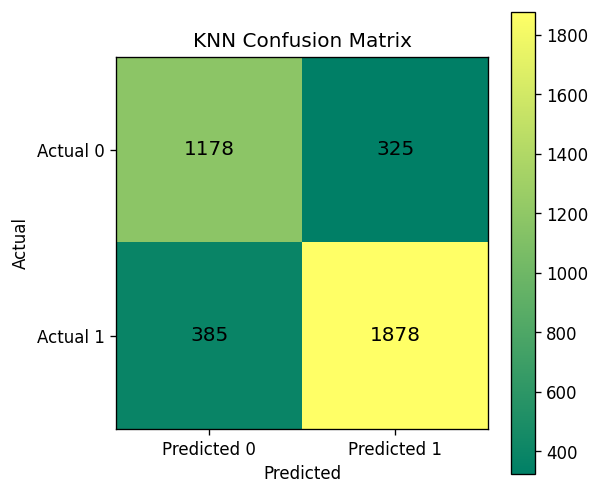

KNN Metrics: {'Accuracy': 0.811, 'Sensitivity (Recall)': 0.784, 'Specificity': 0.83, 'Precision': 0.754, 'F1-Score': 0.768}


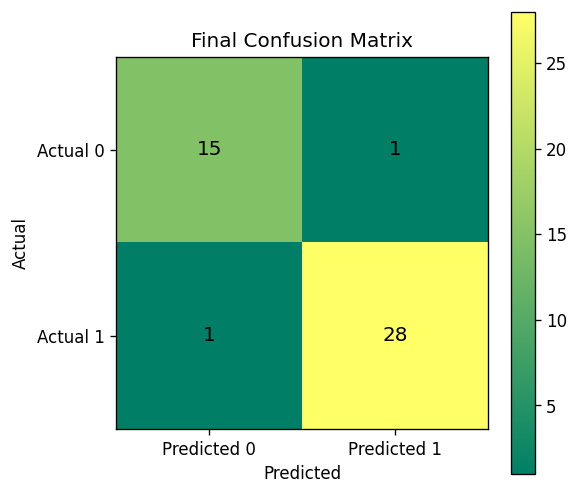

Final Metrics: {'Accuracy': 0.956, 'Sensitivity (Recall)': 0.938, 'Specificity': 0.966, 'Precision': 0.938, 'F1-Score': 0.938}
沒有優化，進行第 1 次優化。
['Diastolic peak' '1st Derivative peak' 'Cycle Area' 'SSI' 'Ratio_CDB_A'
 'Ratio_BA' '1st Derivative cycle' 'Peak to Valley' 'Delta_T'
 'systolic peak' 'Systolic peak y' 'Cardiac cycle' 'Ratio_BDCE_A'
 'Ratio_DA']
Ratio_DA
Fitting 5 folds for each of 20 candidates, totalling 100 fits
最佳參數: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
特徵重要性排序：
                  Feature  Importance
1         Diastolic peak    0.095672
9    1st Derivative peak    0.039899
3             Cycle Area    0.031726
12           Ratio_CDB_A    0.021662
4                    SSI    0.020027
8   1st Derivative cycle    0.016721
10              Ratio_BA    0.016139
11          Ratio_BDCE_A    0.012119
0          systolic peak    0.010818
7                Delta_T    0.010802
5         Peak to Valley    0.010154
2          Cardiac cycle    0.007488
6        S

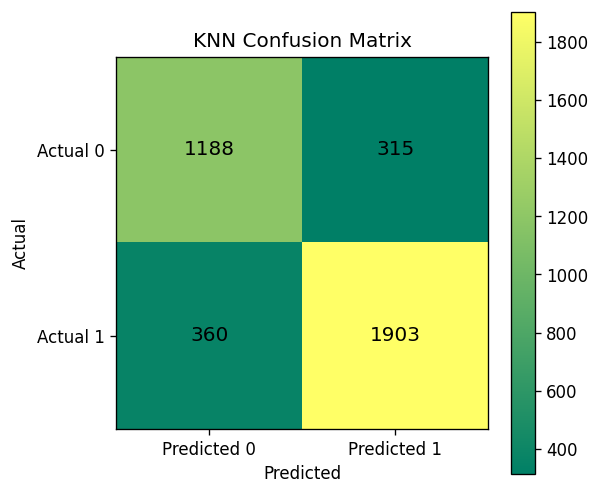

KNN Metrics: {'Accuracy': 0.821, 'Sensitivity (Recall)': 0.79, 'Specificity': 0.841, 'Precision': 0.767, 'F1-Score': 0.779}


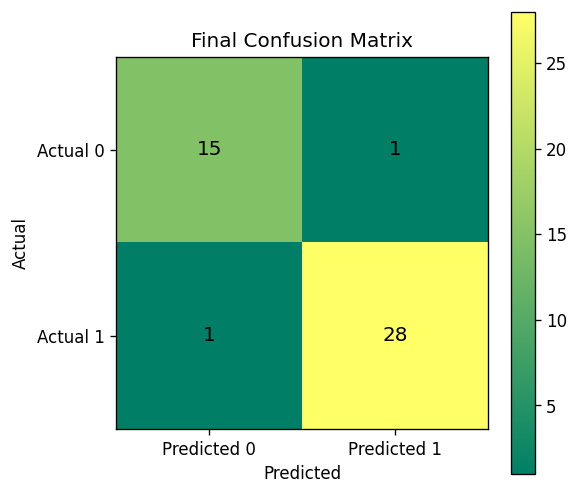

Final Metrics: {'Accuracy': 0.956, 'Sensitivity (Recall)': 0.938, 'Specificity': 0.966, 'Precision': 0.938, 'F1-Score': 0.938}
沒有優化，進行第 2 次優化。
['Diastolic peak' '1st Derivative peak' 'Cycle Area' 'Ratio_CDB_A' 'SSI'
 '1st Derivative cycle' 'Ratio_BA' 'Ratio_BDCE_A' 'systolic peak'
 'Delta_T' 'Peak to Valley' 'Cardiac cycle' 'Systolic peak y']
Systolic peak y
Fitting 5 folds for each of 20 candidates, totalling 100 fits
最佳參數: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
特徵重要性排序：
                  Feature  Importance
1         Diastolic peak    0.090117
8    1st Derivative peak    0.034002
3             Cycle Area    0.031001
11           Ratio_CDB_A    0.012793
4                    SSI    0.012509
7   1st Derivative cycle    0.009851
9               Ratio_BA    0.007130
5         Peak to Valley    0.002817
10          Ratio_BDCE_A    0.002414
2          Cardiac cycle   -0.002698
0          systolic peak   -0.005866
6                Delta_T   -0.006259


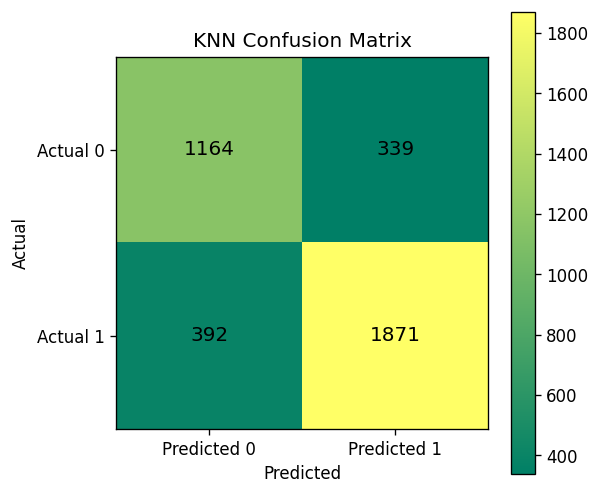

KNN Metrics: {'Accuracy': 0.806, 'Sensitivity (Recall)': 0.774, 'Specificity': 0.827, 'Precision': 0.748, 'F1-Score': 0.761}


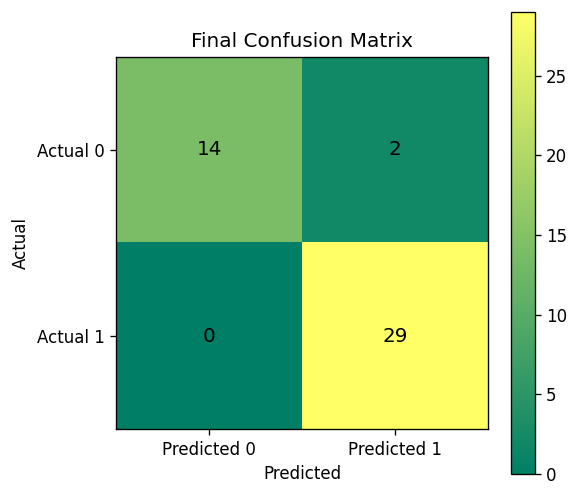

Final Metrics: {'Accuracy': 0.956, 'Sensitivity (Recall)': 0.875, 'Specificity': 1.0, 'Precision': 1.0, 'F1-Score': 0.933}
沒有優化，進行第 3 次優化。
['Diastolic peak' '1st Derivative peak' 'Cycle Area' 'Ratio_CDB_A' 'SSI'
 '1st Derivative cycle' 'Ratio_BA' 'Peak to Valley' 'Ratio_BDCE_A'
 'Cardiac cycle' 'systolic peak' 'Delta_T']
Delta_T
Fitting 5 folds for each of 20 candidates, totalling 100 fits
最佳參數: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
特徵重要性排序：
                  Feature  Importance
1         Diastolic peak    0.105818
0          systolic peak    0.091309
7    1st Derivative peak    0.044920
3             Cycle Area    0.042512
4                    SSI    0.024073
10           Ratio_CDB_A    0.021006
6   1st Derivative cycle    0.019565
8               Ratio_BA    0.019010
5         Peak to Valley    0.012924
9           Ratio_BDCE_A    0.010704
2          Cardiac cycle    0.010621


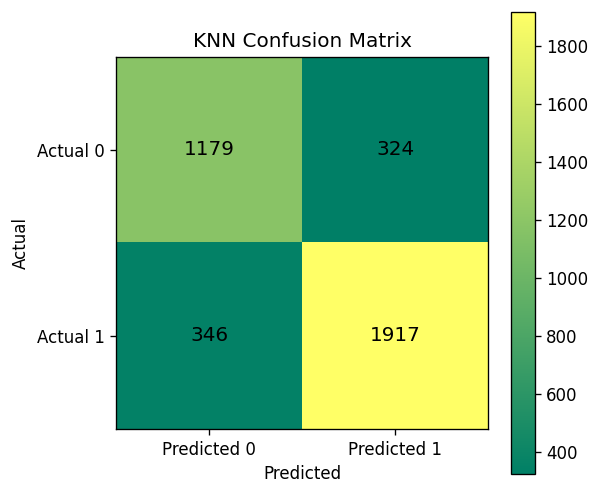

KNN Metrics: {'Accuracy': 0.822, 'Sensitivity (Recall)': 0.784, 'Specificity': 0.847, 'Precision': 0.773, 'F1-Score': 0.779}


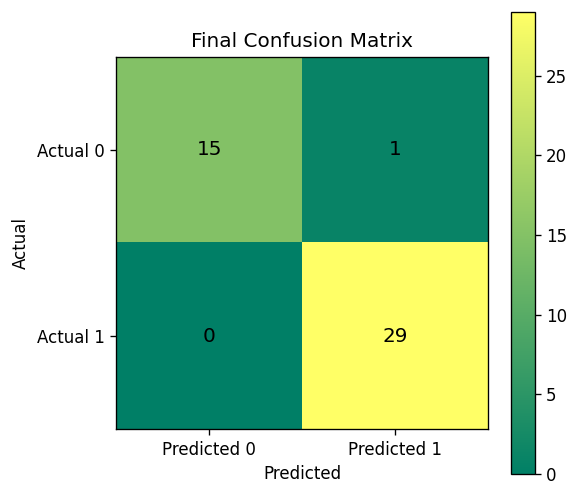

Final Metrics: {'Accuracy': 0.978, 'Sensitivity (Recall)': 0.938, 'Specificity': 1.0, 'Precision': 1.0, 'F1-Score': 0.968}
Accuracy improved from 0.956 to 0.978.
Results saved to KNN_Results.csv
Results saved to KNN_Results_Final.csv
['Diastolic peak' 'systolic peak' '1st Derivative peak' 'Cycle Area' 'SSI'
 'Ratio_CDB_A' '1st Derivative cycle' 'Ratio_BA' 'Peak to Valley'
 'Ratio_BDCE_A' 'Cardiac cycle']
Cardiac cycle
Fitting 5 folds for each of 20 candidates, totalling 100 fits
最佳參數: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
特徵重要性排序：
                 Feature  Importance
1        Diastolic peak    0.107929
0         systolic peak    0.088444
6   1st Derivative peak    0.041604
2            Cycle Area    0.038367
5  1st Derivative cycle    0.023887
3                   SSI    0.023672
9           Ratio_CDB_A    0.016397
7              Ratio_BA    0.015210
4        Peak to Valley    0.011253
8          Ratio_BDCE_A    0.007169


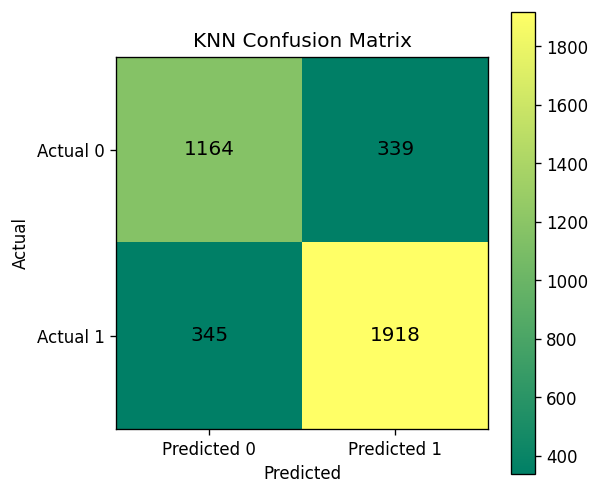

KNN Metrics: {'Accuracy': 0.818, 'Sensitivity (Recall)': 0.774, 'Specificity': 0.848, 'Precision': 0.771, 'F1-Score': 0.773}


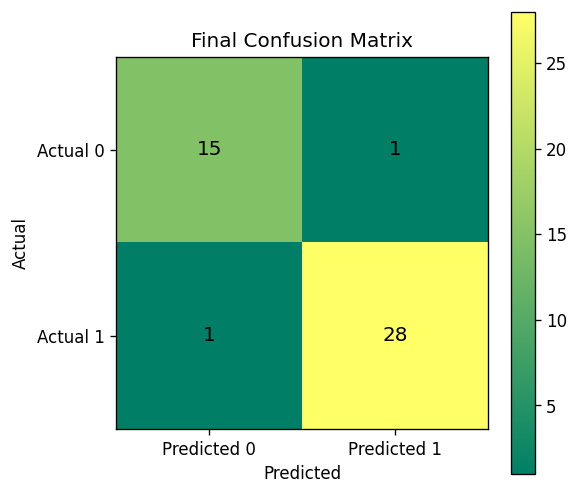

Final Metrics: {'Accuracy': 0.956, 'Sensitivity (Recall)': 0.938, 'Specificity': 0.966, 'Precision': 0.938, 'F1-Score': 0.938}
沒有優化，進行第 4 次優化。
['Diastolic peak' 'systolic peak' '1st Derivative peak' 'Cycle Area'
 '1st Derivative cycle' 'SSI' 'Ratio_CDB_A' 'Ratio_BA' 'Peak to Valley'
 'Ratio_BDCE_A']
Ratio_BDCE_A
Fitting 5 folds for each of 20 candidates, totalling 100 fits
最佳參數: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
特徵重要性排序：
                 Feature  Importance
1        Diastolic peak    0.118417
0         systolic peak    0.103173
8           Ratio_CDB_A    0.060730
6   1st Derivative peak    0.050847
2            Cycle Area    0.046328
3                   SSI    0.032685
7              Ratio_BA    0.027576
5  1st Derivative cycle    0.026516
4        Peak to Valley    0.013192


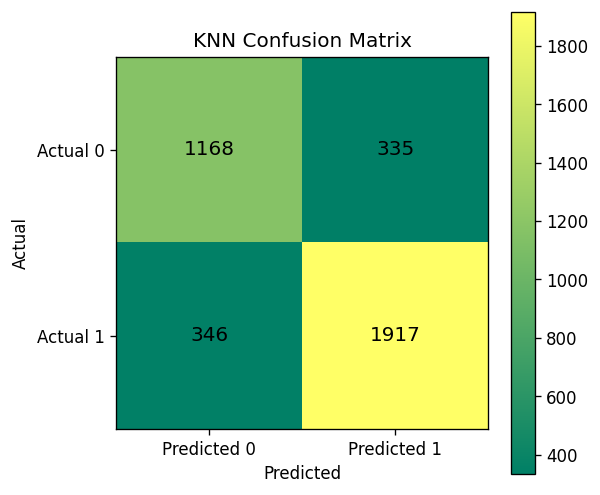

KNN Metrics: {'Accuracy': 0.819, 'Sensitivity (Recall)': 0.777, 'Specificity': 0.847, 'Precision': 0.771, 'F1-Score': 0.774}


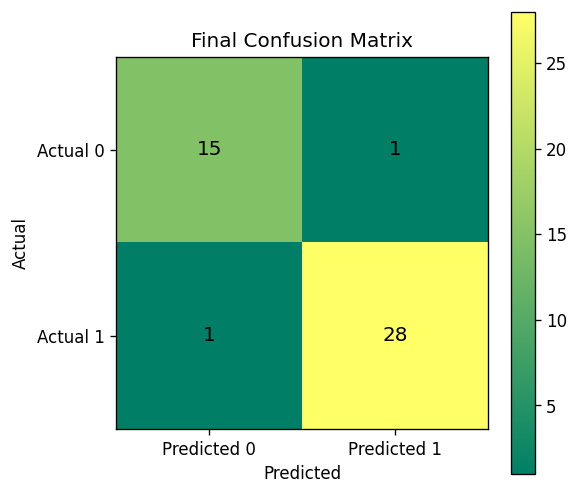

Final Metrics: {'Accuracy': 0.956, 'Sensitivity (Recall)': 0.938, 'Specificity': 0.966, 'Precision': 0.938, 'F1-Score': 0.938}
沒有優化，進行第 5 次優化。
['Diastolic peak' 'systolic peak' 'Ratio_CDB_A' '1st Derivative peak'
 'Cycle Area' 'SSI' 'Ratio_BA' '1st Derivative cycle' 'Peak to Valley']
Peak to Valley
Fitting 5 folds for each of 20 candidates, totalling 100 fits
最佳參數: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
特徵重要性排序：
                 Feature  Importance
0         systolic peak    0.138611
1        Diastolic peak    0.120531
7           Ratio_CDB_A    0.065404
5   1st Derivative peak    0.052674
2            Cycle Area    0.045489
3                   SSI    0.030627
6              Ratio_BA    0.029740
4  1st Derivative cycle    0.026301


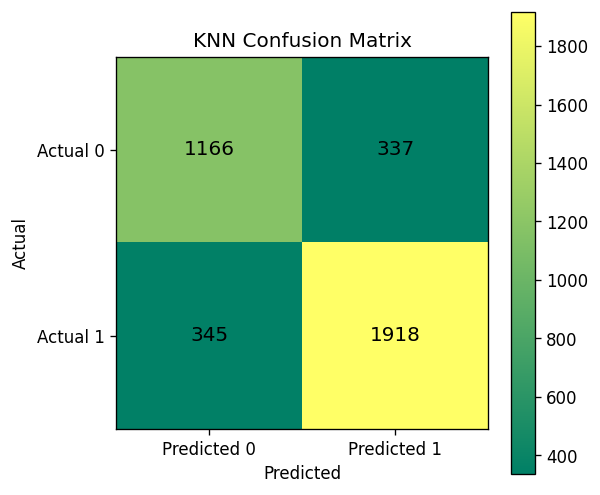

KNN Metrics: {'Accuracy': 0.819, 'Sensitivity (Recall)': 0.776, 'Specificity': 0.848, 'Precision': 0.772, 'F1-Score': 0.774}


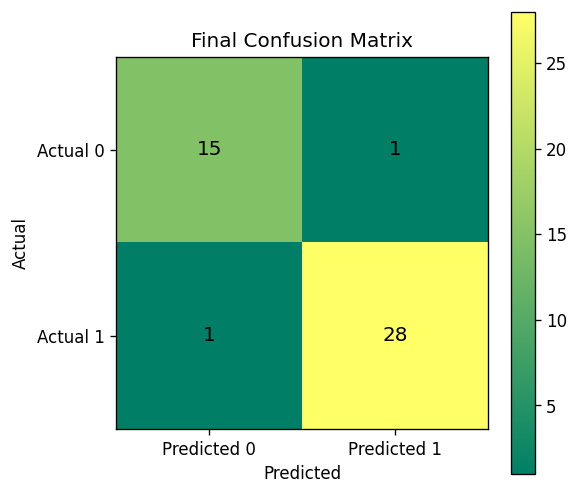

Final Metrics: {'Accuracy': 0.956, 'Sensitivity (Recall)': 0.938, 'Specificity': 0.966, 'Precision': 0.938, 'F1-Score': 0.938}
沒有優化，進行第 6 次優化。
['systolic peak' 'Diastolic peak' 'Ratio_CDB_A' '1st Derivative peak'
 'Cycle Area' 'SSI' 'Ratio_BA' '1st Derivative cycle']
1st Derivative cycle
Fitting 5 folds for each of 20 candidates, totalling 100 fits
最佳參數: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
特徵重要性排序：
                Feature  Importance
0        systolic peak    0.143136
1       Diastolic peak    0.122884
6          Ratio_CDB_A    0.075595
4  1st Derivative peak    0.060844
2           Cycle Area    0.055204
5             Ratio_BA    0.039132
3                  SSI    0.036612


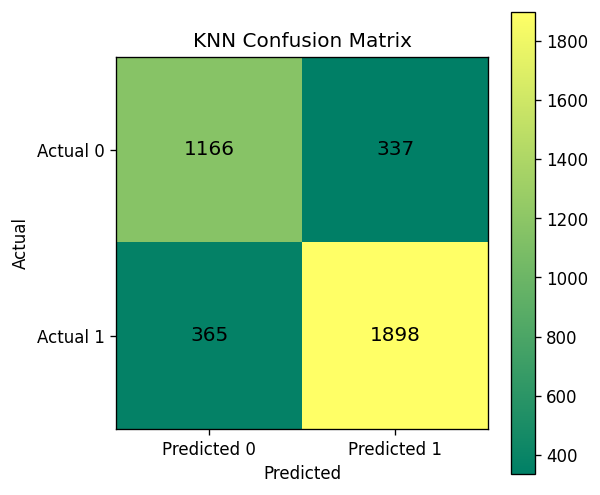

KNN Metrics: {'Accuracy': 0.814, 'Sensitivity (Recall)': 0.776, 'Specificity': 0.839, 'Precision': 0.762, 'F1-Score': 0.769}


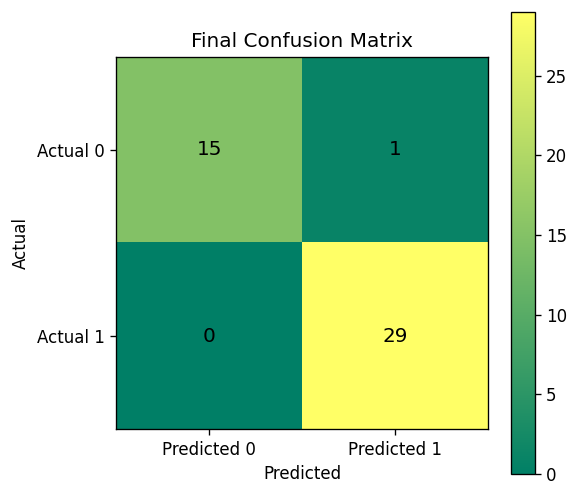

Final Metrics: {'Accuracy': 0.978, 'Sensitivity (Recall)': 0.938, 'Specificity': 1.0, 'Precision': 1.0, 'F1-Score': 0.968}
Accuracy improved from 0.956 to 0.978.
Results saved to KNN_Results.csv
Results saved to KNN_Results_Final.csv
['systolic peak' 'Diastolic peak' 'Ratio_CDB_A' '1st Derivative peak'
 'Cycle Area' 'Ratio_BA' 'SSI']
SSI
Fitting 5 folds for each of 20 candidates, totalling 100 fits
最佳參數: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
特徵重要性排序：
                Feature  Importance
0        systolic peak    0.151702
1       Diastolic peak    0.132496
5          Ratio_CDB_A    0.097738
3  1st Derivative peak    0.082095
2           Cycle Area    0.071989
4             Ratio_BA    0.054018


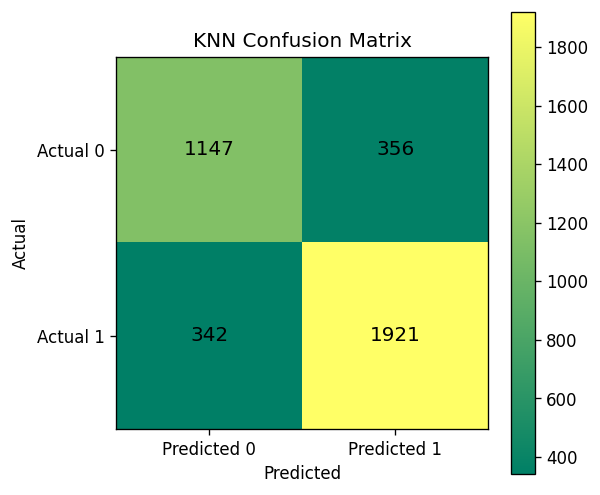

KNN Metrics: {'Accuracy': 0.815, 'Sensitivity (Recall)': 0.763, 'Specificity': 0.849, 'Precision': 0.77, 'F1-Score': 0.767}


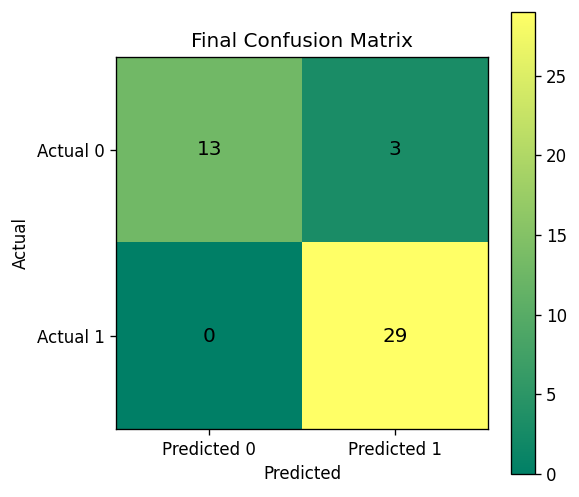

Final Metrics: {'Accuracy': 0.933, 'Sensitivity (Recall)': 0.812, 'Specificity': 1.0, 'Precision': 1.0, 'F1-Score': 0.897}
進行五次都沒有顯著提升，停止優化。


In [ ]:
times = 0
while Best_metrics != {'Accuracy': 0, 'Sensitivity': 0, 'Specificity': 0, 'Precision': 0, 'F1-Score': 0}:
    print(feature_importance_df['Feature'].values)
    print(feature_importance_df['Feature'].values[-1])

    # 獲取要刪除的特徵
    Delete_Feature = feature_importance_df['Feature'].values[-1]
    Delete_Index = Modify_KNN_X.columns.get_loc(Delete_Feature)  # 取得該特徵在列中的位置

    # 刪除特徵列：從 X_train 和 X_test 中刪除該特徵
    Modify_KNN_X_train = np.delete(Modify_KNN_X_train, Delete_Index, axis=1)
    Modify_KNN_X_test = np.delete(Modify_KNN_X_test, Delete_Index, axis=1)

    # 更新 Modify_X（原始資料），刪除該特徵列
    Modify_KNN_X = Modify_KNN_X.drop(Delete_Feature, axis=1)



    # 呼叫訓練和評估 KNN 模型，並傳遞更新後的特徵集
    knn_model, knn_metrics, knn_conf_matrix, knn_y_pred, feature_importance_df = train_knn(Modify_KNN_X_train, Modify_KNN_y_train, Modify_KNN_X_test, Modify_KNN_y_test, Modify_KNN_X.columns)

    # 顯示混淆矩陣
    plot_confusion_matrix(knn_conf_matrix, title='KNN Confusion Matrix')

    # 顯示 KNN 評估指標
    print("KNN Metrics:", knn_metrics)

    # 儲存結果並更新 Best_metrics
    Best_metrics, times = save_results_to_csv('KNN_Results', info_test, y_test, knn_y_pred, Best_metrics, times)

In [ ]:
info_columns = data[['Name', 'i', 'Bad', 'hands']]
X = data.iloc[:, 5:]  # 特徵列
y = data['label']     # 標籤
#印出x的標題
print(X.columns)

# 分割訓練和測試集
X_train, X_test, y_train, y_test, info_train, info_test = train_test_split(X, y, info_columns, test_size=0.3, random_state=42)

# 特徵標準化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Index(['systolic peak', 'Diastolic peak', 'Cardiac cycle', 'Cycle Area', 'SSI',
       'Peak to Valley', 'Systolic peak y', 'Delta_T', '1st Derivative cycle',
       '1st Derivative peak', 'Ratio_BA', 'Ratio_CA', 'Ratio_DA',
       'Ratio_BDCE_A', 'Ratio_CDB_A'],
      dtype='object')


Fitting 5 folds for each of 36 candidates, totalling 180 fits
最佳參數: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
特徵重要性排序：
                  Feature  Importance
1         Diastolic peak    0.102309
9    1st Derivative peak    0.087529
3             Cycle Area    0.086463
10              Ratio_BA    0.085323
7                Delta_T    0.076921
14           Ratio_CDB_A    0.073200
0          systolic peak    0.062337
13          Ratio_BDCE_A    0.061317
11              Ratio_CA    0.060025
5         Peak to Valley    0.059183
12              Ratio_DA    0.059005
6        Systolic peak y    0.053229
4                    SSI    0.047045
2          Cardiac cycle    0.044838
8   1st Derivative cycle    0.041275


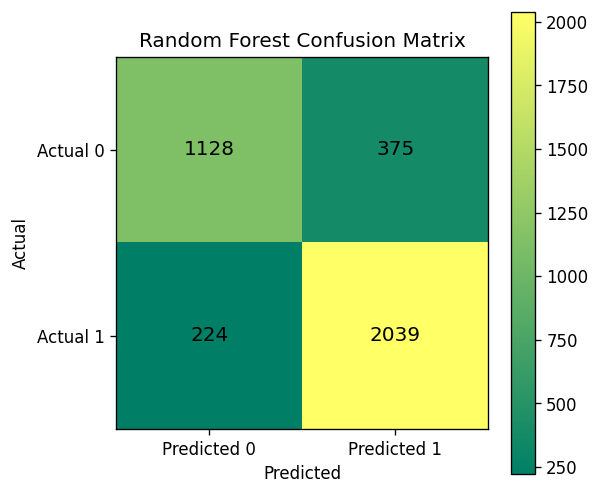

Random Forest Metrics: {'Accuracy': 0.841, 'Sensitivity (Recall)': 0.75, 'Specificity': 0.901, 'Precision': 0.834, 'F1-Score': 0.79}


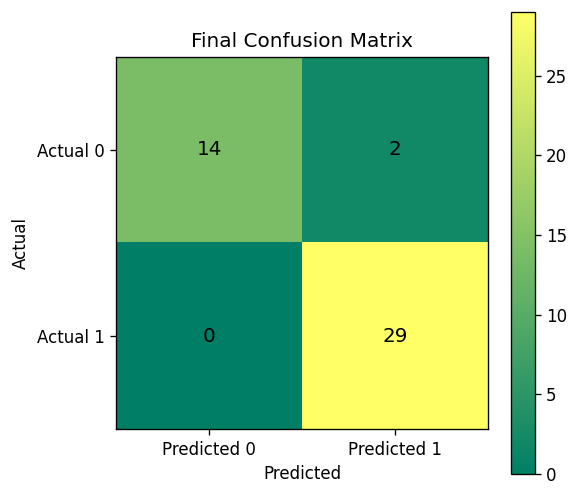

Final Metrics: {'Accuracy': 0.956, 'Sensitivity (Recall)': 0.875, 'Specificity': 1.0, 'Precision': 1.0, 'F1-Score': 0.933}
Accuracy improved from 0 to 0.956.
Results saved to RF_Results.csv
Results saved to RF_Results_Final.csv


In [ ]:
def train_rf(X_train, y_train, X_test, y_test, X_columns):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'class_weight': ['balanced']
    }

    rf_grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    rf_grid_search.fit(X_train, y_train)

    best_model = rf_grid_search.best_estimator_
    best_params = rf_grid_search.best_params_
    y_pred = best_model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    metrics = calculate_metrics(conf_matrix)

        # 特徵重要性 - Random Forest 原生支援
    feature_importance = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': X_columns,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

    print("最佳參數:", best_params)
    print("特徵重要性排序：\n", feature_importance_df)
    
    return best_model, metrics, conf_matrix, y_pred, feature_importance_df

# Random Forest
rf_model, rf_metrics, rf_conf_matrix, rf_y_pred, feature_importance_df = train_rf(X_train, y_train, X_test, y_test, X.columns)
plot_confusion_matrix(rf_conf_matrix, title='Random Forest Confusion Matrix')
print("Random Forest Metrics:", rf_metrics)
Best_metrics, times = save_results_to_csv('RF_Results', info_test, y_test, rf_y_pred, Best_metrics, times)


In [ ]:
Modify_RF_X = X
Modify_RF_X_train = X_train
Modify_RF_X_test = X_test
Modify_RF_y_train = y_train
Modify_RF_y_test = y_test

['Diastolic peak' '1st Derivative peak' 'Cycle Area' 'Ratio_BA' 'Delta_T'
 'Ratio_CDB_A' 'systolic peak' 'Ratio_BDCE_A' 'Ratio_CA' 'Peak to Valley'
 'Ratio_DA' 'Systolic peak y' 'SSI' 'Cardiac cycle' '1st Derivative cycle']
1st Derivative cycle
Fitting 5 folds for each of 36 candidates, totalling 180 fits
最佳參數: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
特徵重要性排序：
                 Feature  Importance
1        Diastolic peak    0.102780
8   1st Derivative peak    0.092758
9              Ratio_BA    0.088649
3            Cycle Area    0.087680
7               Delta_T    0.078046
13          Ratio_CDB_A    0.074775
0         systolic peak    0.066706
12         Ratio_BDCE_A    0.064289
10             Ratio_CA    0.062581
11             Ratio_DA    0.060436
5        Peak to Valley    0.060256
6       Systolic peak y    0.057483
4                   SSI    0.053067
2         Cardiac cycle    0.050495


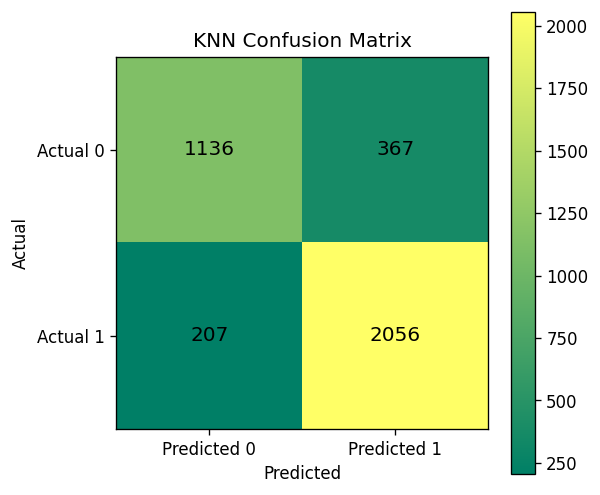

rf Metrics: {'Accuracy': 0.848, 'Sensitivity (Recall)': 0.756, 'Specificity': 0.909, 'Precision': 0.846, 'F1-Score': 0.798}


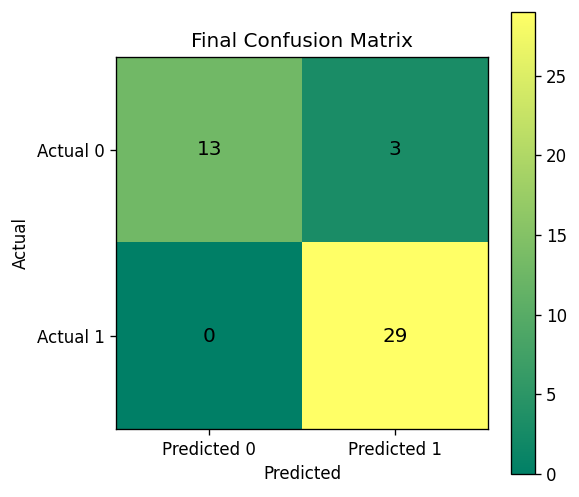

Final Metrics: {'Accuracy': 0.933, 'Sensitivity (Recall)': 0.812, 'Specificity': 1.0, 'Precision': 1.0, 'F1-Score': 0.897}
沒有優化，進行第 1 次優化。
['Diastolic peak' '1st Derivative peak' 'Ratio_BA' 'Cycle Area' 'Delta_T'
 'Ratio_CDB_A' 'systolic peak' 'Ratio_BDCE_A' 'Ratio_CA' 'Ratio_DA'
 'Peak to Valley' 'Systolic peak y' 'SSI' 'Cardiac cycle']
Cardiac cycle
Fitting 5 folds for each of 36 candidates, totalling 180 fits
最佳參數: {'class_weight': 'balanced', 'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 200}
特徵重要性排序：
                 Feature  Importance
1        Diastolic peak    0.107573
7   1st Derivative peak    0.096931
8              Ratio_BA    0.093301
2            Cycle Area    0.093042
6               Delta_T    0.080798
12          Ratio_CDB_A    0.079180
0         systolic peak    0.069484
11         Ratio_BDCE_A    0.067149
9              Ratio_CA    0.066017
10             Ratio_DA    0.063195
5       Systolic peak y    0.063086
4        Peak to Valley    0.063062
3        

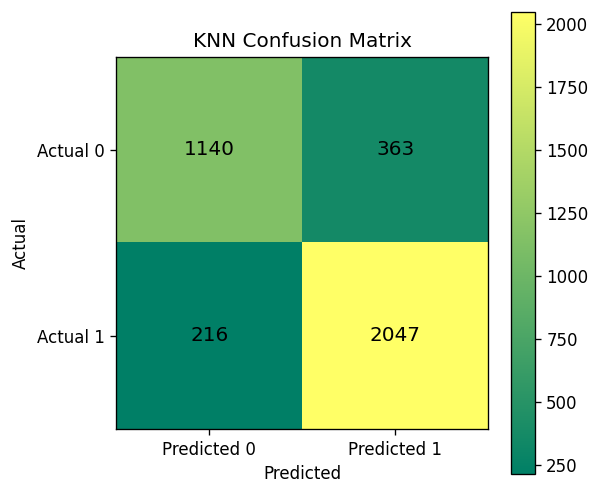

rf Metrics: {'Accuracy': 0.846, 'Sensitivity (Recall)': 0.758, 'Specificity': 0.905, 'Precision': 0.841, 'F1-Score': 0.797}


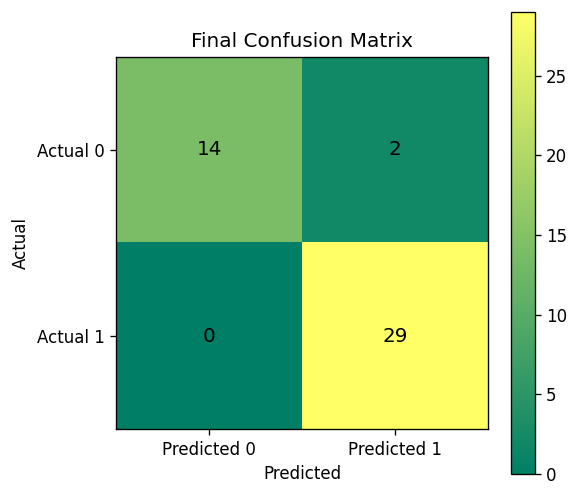

Final Metrics: {'Accuracy': 0.956, 'Sensitivity (Recall)': 0.875, 'Specificity': 1.0, 'Precision': 1.0, 'F1-Score': 0.933}
Accuracy improved from 0.933 to 0.956.
Results saved to RF_Results.csv
Results saved to RF_Results_Final.csv
['Diastolic peak' '1st Derivative peak' 'Ratio_BA' 'Cycle Area' 'Delta_T'
 'Ratio_CDB_A' 'systolic peak' 'Ratio_BDCE_A' 'Ratio_CA' 'Ratio_DA'
 'Systolic peak y' 'Peak to Valley' 'SSI']
SSI
Fitting 5 folds for each of 36 candidates, totalling 180 fits
最佳參數: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
特徵重要性排序：
                 Feature  Importance
1        Diastolic peak    0.116973
6   1st Derivative peak    0.105676
2            Cycle Area    0.101609
7              Ratio_BA    0.099115
5               Delta_T    0.086469
11          Ratio_CDB_A    0.083208
0         systolic peak    0.071240
10         Ratio_BDCE_A    0.071182
8              Ratio_CA    0.068523
3        Peak to Valley    0.065737
9           

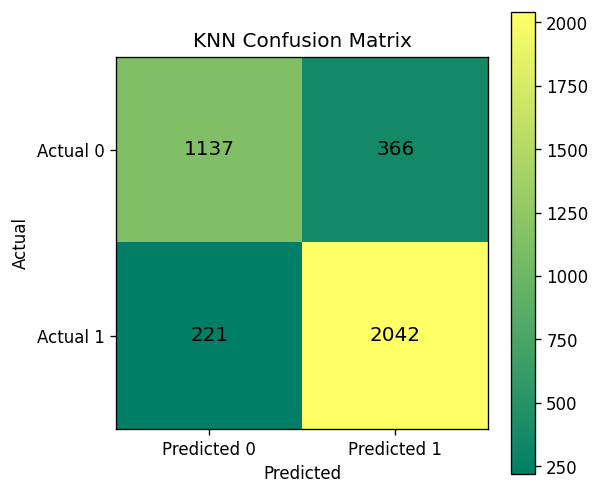

rf Metrics: {'Accuracy': 0.844, 'Sensitivity (Recall)': 0.756, 'Specificity': 0.902, 'Precision': 0.837, 'F1-Score': 0.795}


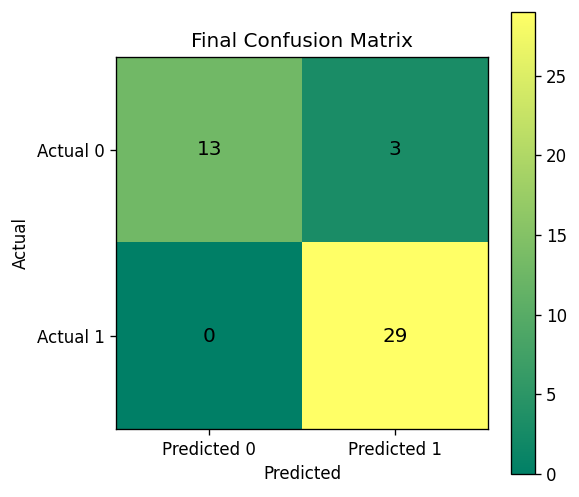

Final Metrics: {'Accuracy': 0.933, 'Sensitivity (Recall)': 0.812, 'Specificity': 1.0, 'Precision': 1.0, 'F1-Score': 0.897}
沒有優化，進行第 2 次優化。
['Diastolic peak' '1st Derivative peak' 'Cycle Area' 'Ratio_BA' 'Delta_T'
 'Ratio_CDB_A' 'systolic peak' 'Ratio_BDCE_A' 'Ratio_CA' 'Peak to Valley'
 'Ratio_DA' 'Systolic peak y']
Systolic peak y
Fitting 5 folds for each of 36 candidates, totalling 180 fits
最佳參數: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
特徵重要性排序：
                 Feature  Importance
1        Diastolic peak    0.124196
5   1st Derivative peak    0.110747
2            Cycle Area    0.108857
6              Ratio_BA    0.103980
4               Delta_T    0.088998
10          Ratio_CDB_A    0.088850
0         systolic peak    0.076543
9          Ratio_BDCE_A    0.076391
7              Ratio_CA    0.076160
8              Ratio_DA    0.073165
3        Peak to Valley    0.072112


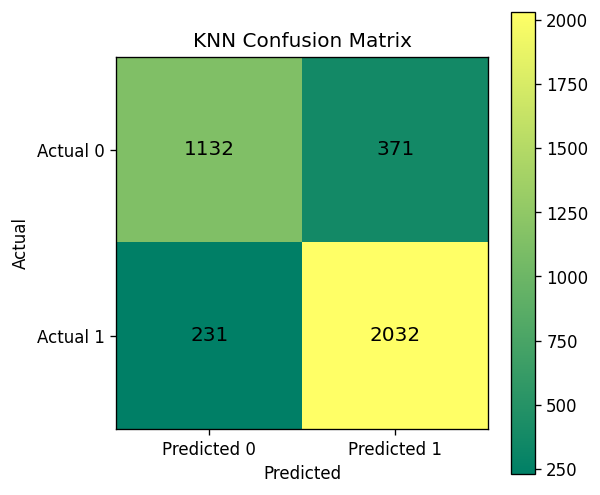

rf Metrics: {'Accuracy': 0.84, 'Sensitivity (Recall)': 0.753, 'Specificity': 0.898, 'Precision': 0.831, 'F1-Score': 0.79}


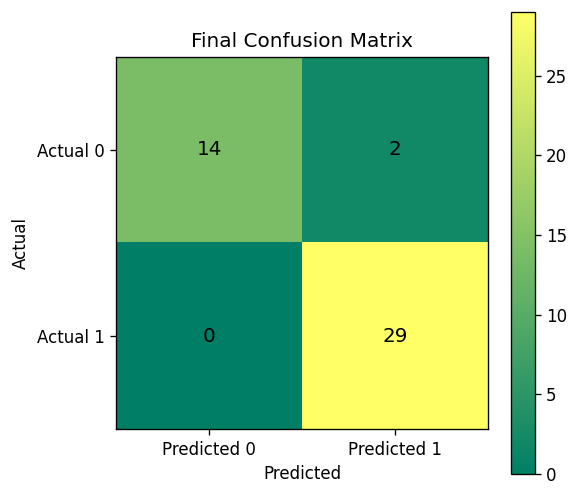

Final Metrics: {'Accuracy': 0.956, 'Sensitivity (Recall)': 0.875, 'Specificity': 1.0, 'Precision': 1.0, 'F1-Score': 0.933}
Accuracy improved from 0.933 to 0.956.
Results saved to RF_Results.csv
Results saved to RF_Results_Final.csv
['Diastolic peak' '1st Derivative peak' 'Cycle Area' 'Ratio_BA' 'Delta_T'
 'Ratio_CDB_A' 'systolic peak' 'Ratio_BDCE_A' 'Ratio_CA' 'Ratio_DA'
 'Peak to Valley']
Peak to Valley
Fitting 5 folds for each of 36 candidates, totalling 180 fits
最佳參數: {'class_weight': 'balanced', 'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 100}
特徵重要性排序：
                Feature  Importance
1       Diastolic peak    0.128016
4  1st Derivative peak    0.116078
2           Cycle Area    0.112228
3              Delta_T    0.110608
5             Ratio_BA    0.110525
9          Ratio_CDB_A    0.092551
0        systolic peak    0.091625
8         Ratio_BDCE_A    0.079790
7             Ratio_DA    0.079757
6             Ratio_CA    0.078823


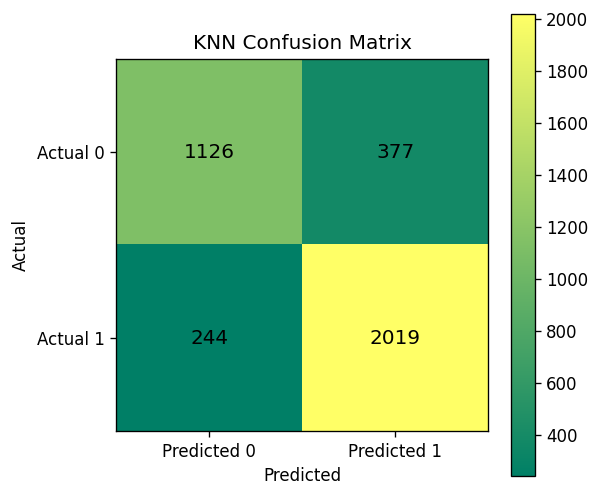

rf Metrics: {'Accuracy': 0.835, 'Sensitivity (Recall)': 0.749, 'Specificity': 0.892, 'Precision': 0.822, 'F1-Score': 0.784}


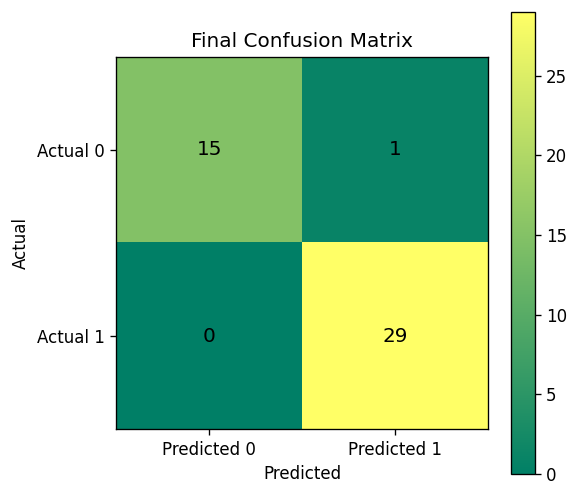

Final Metrics: {'Accuracy': 0.978, 'Sensitivity (Recall)': 0.938, 'Specificity': 1.0, 'Precision': 1.0, 'F1-Score': 0.968}
Accuracy improved from 0.956 to 0.978.
Results saved to RF_Results.csv
Results saved to RF_Results_Final.csv
['Diastolic peak' '1st Derivative peak' 'Cycle Area' 'Delta_T' 'Ratio_BA'
 'Ratio_CDB_A' 'systolic peak' 'Ratio_BDCE_A' 'Ratio_DA' 'Ratio_CA']
Ratio_CA
Fitting 5 folds for each of 36 candidates, totalling 180 fits
最佳參數: {'class_weight': 'balanced', 'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 100}
特徵重要性排序：
                Feature  Importance
1       Diastolic peak    0.136330
4  1st Derivative peak    0.124640
2           Cycle Area    0.122633
3              Delta_T    0.117182
5             Ratio_BA    0.116749
8          Ratio_CDB_A    0.105695
7         Ratio_BDCE_A    0.096969
0        systolic peak    0.093645
6             Ratio_DA    0.086158


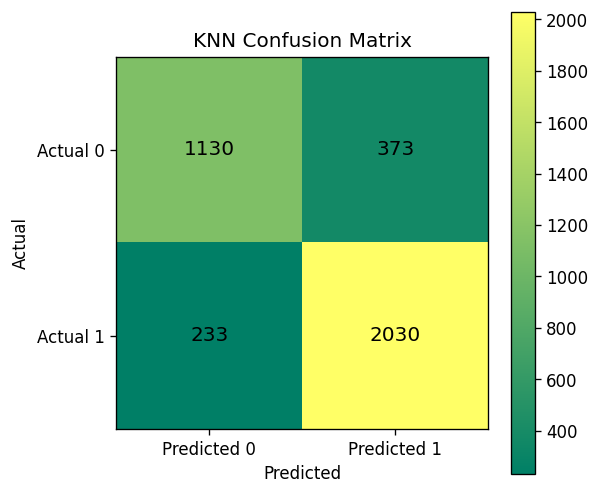

rf Metrics: {'Accuracy': 0.839, 'Sensitivity (Recall)': 0.752, 'Specificity': 0.897, 'Precision': 0.829, 'F1-Score': 0.789}


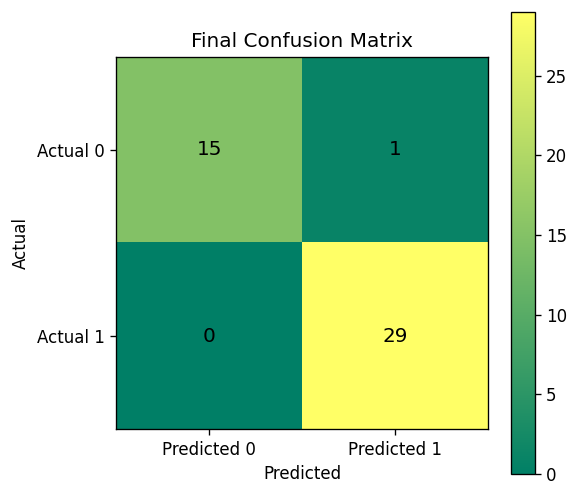

Final Metrics: {'Accuracy': 0.978, 'Sensitivity (Recall)': 0.938, 'Specificity': 1.0, 'Precision': 1.0, 'F1-Score': 0.968}
沒有優化，進行第 3 次優化。
['Diastolic peak' '1st Derivative peak' 'Cycle Area' 'Delta_T' 'Ratio_BA'
 'Ratio_CDB_A' 'Ratio_BDCE_A' 'systolic peak' 'Ratio_DA']
Ratio_DA
Fitting 5 folds for each of 36 candidates, totalling 180 fits
最佳參數: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
特徵重要性排序：
                Feature  Importance
1       Diastolic peak    0.142028
4  1st Derivative peak    0.132254
5             Ratio_BA    0.127984
2           Cycle Area    0.127543
3              Delta_T    0.123993
7          Ratio_CDB_A    0.120122
6         Ratio_BDCE_A    0.118443
0        systolic peak    0.107634


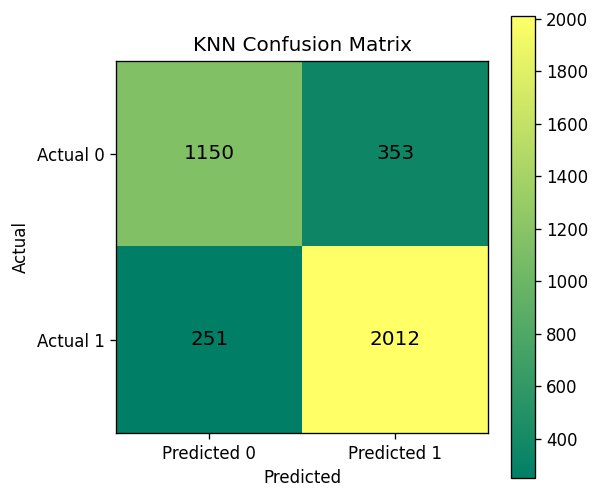

rf Metrics: {'Accuracy': 0.84, 'Sensitivity (Recall)': 0.765, 'Specificity': 0.889, 'Precision': 0.821, 'F1-Score': 0.792}


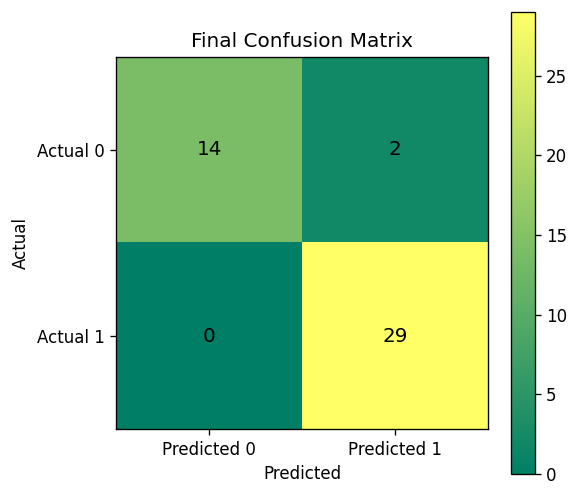

Final Metrics: {'Accuracy': 0.956, 'Sensitivity (Recall)': 0.875, 'Specificity': 1.0, 'Precision': 1.0, 'F1-Score': 0.933}
沒有優化，進行第 4 次優化。
['Diastolic peak' '1st Derivative peak' 'Ratio_BA' 'Cycle Area' 'Delta_T'
 'Ratio_CDB_A' 'Ratio_BDCE_A' 'systolic peak']
systolic peak
Fitting 5 folds for each of 36 candidates, totalling 180 fits
最佳參數: {'class_weight': 'balanced', 'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 200}
特徵重要性排序：
                Feature  Importance
2              Delta_T    0.170147
0       Diastolic peak    0.147848
3  1st Derivative peak    0.145028
1           Cycle Area    0.138153
4             Ratio_BA    0.137692
6          Ratio_CDB_A    0.131399
5         Ratio_BDCE_A    0.129733


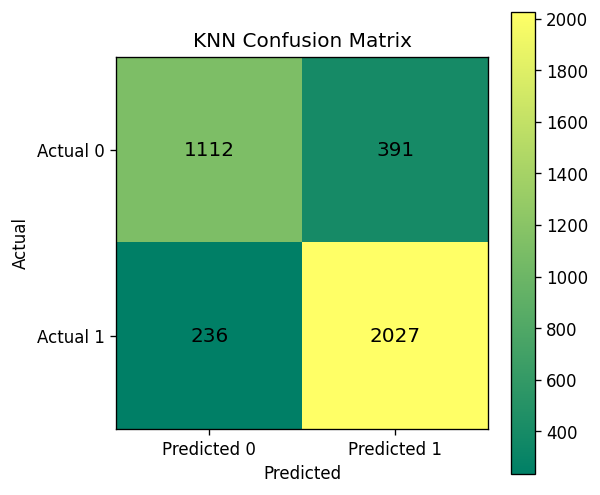

rf Metrics: {'Accuracy': 0.834, 'Sensitivity (Recall)': 0.74, 'Specificity': 0.896, 'Precision': 0.825, 'F1-Score': 0.78}


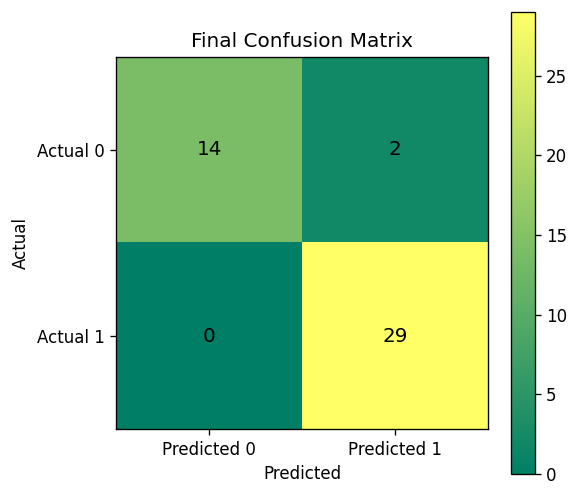

Final Metrics: {'Accuracy': 0.956, 'Sensitivity (Recall)': 0.875, 'Specificity': 1.0, 'Precision': 1.0, 'F1-Score': 0.933}
沒有優化，進行第 5 次優化。
['Delta_T' 'Diastolic peak' '1st Derivative peak' 'Cycle Area' 'Ratio_BA'
 'Ratio_CDB_A' 'Ratio_BDCE_A']
Ratio_BDCE_A
Fitting 5 folds for each of 36 candidates, totalling 180 fits
最佳參數: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
特徵重要性排序：
                Feature  Importance
2              Delta_T    0.195689
5          Ratio_CDB_A    0.165501
0       Diastolic peak    0.164690
3  1st Derivative peak    0.161979
4             Ratio_BA    0.158016
1           Cycle Area    0.154125


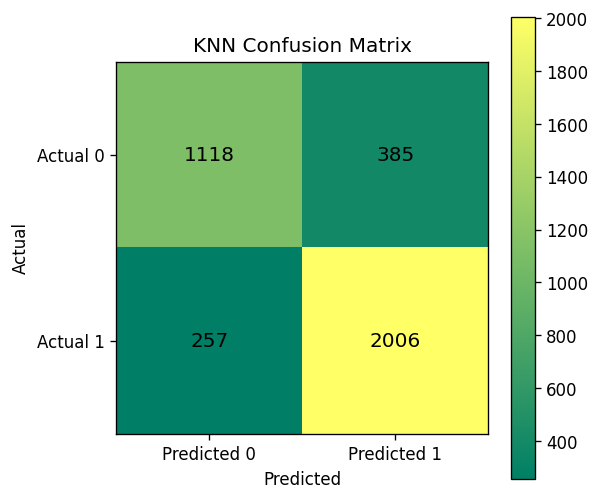

rf Metrics: {'Accuracy': 0.83, 'Sensitivity (Recall)': 0.744, 'Specificity': 0.886, 'Precision': 0.813, 'F1-Score': 0.777}


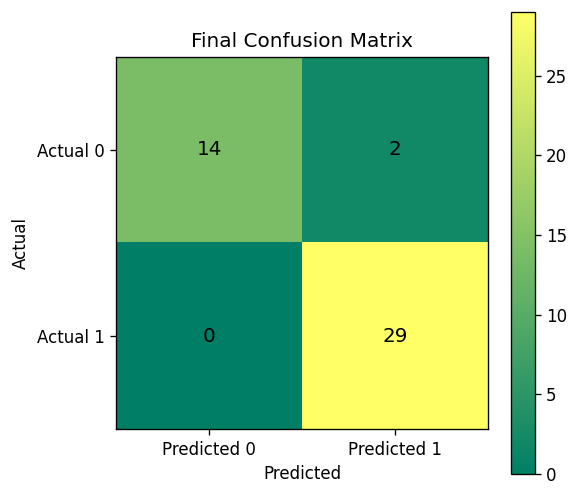

Final Metrics: {'Accuracy': 0.956, 'Sensitivity (Recall)': 0.875, 'Specificity': 1.0, 'Precision': 1.0, 'F1-Score': 0.933}
沒有優化，進行第 6 次優化。
['Delta_T' 'Ratio_CDB_A' 'Diastolic peak' '1st Derivative peak' 'Ratio_BA'
 'Cycle Area']
Cycle Area
Fitting 5 folds for each of 36 candidates, totalling 180 fits
最佳參數: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
特徵重要性排序：
                Feature  Importance
1              Delta_T    0.228588
0       Diastolic peak    0.203003
4          Ratio_CDB_A    0.190526
2  1st Derivative peak    0.190046
3             Ratio_BA    0.187837


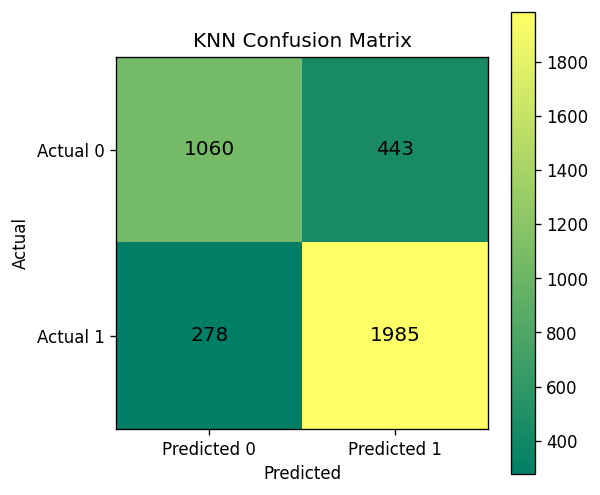

rf Metrics: {'Accuracy': 0.809, 'Sensitivity (Recall)': 0.705, 'Specificity': 0.877, 'Precision': 0.792, 'F1-Score': 0.746}


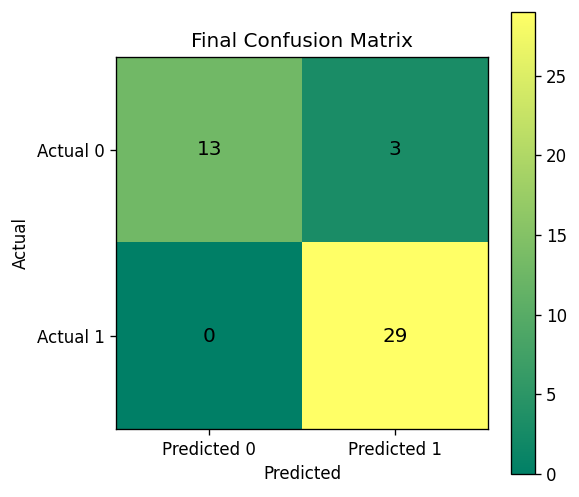

Final Metrics: {'Accuracy': 0.933, 'Sensitivity (Recall)': 0.812, 'Specificity': 1.0, 'Precision': 1.0, 'F1-Score': 0.897}
進行五次都沒有顯著提升，停止優化。


In [ ]:
times = 0
while Best_metrics != {'Accuracy': 0, 'Sensitivity': 0, 'Specificity': 0, 'Precision': 0, 'F1-Score': 0}:
    print(feature_importance_df['Feature'].values)
    print(feature_importance_df['Feature'].values[-1])

    # 獲取要刪除的特徵
    Delete_Feature = feature_importance_df['Feature'].values[-1]
    Delete_Index = Modify_RF_X.columns.get_loc(Delete_Feature)  # 取得該特徵在列中的位置

    # 刪除特徵列：從 X_train 和 X_test 中刪除該特徵
    Modify_RF_X_train = np.delete(Modify_RF_X_train, Delete_Index, axis=1)
    Modify_RF_X_test = np.delete(Modify_RF_X_test, Delete_Index, axis=1)

    # 更新 Modify_X（原始資料），刪除該特徵列
    Modify_RF_X = Modify_RF_X.drop(Delete_Feature, axis=1)



    # 呼叫訓練和評估 KNN 模型，並傳遞更新後的特徵集
    RF_model, RF_metrics, RF_conf_matrix, RF_y_pred, feature_importance_df = train_rf(Modify_RF_X_train, Modify_RF_y_train, Modify_RF_X_test, Modify_RF_y_test, Modify_RF_X.columns)

    # 顯示混淆矩陣
    plot_confusion_matrix(RF_conf_matrix, title='KNN Confusion Matrix')

    # 顯示 KNN 評估指標
    print("rf Metrics:", RF_metrics)

    # 儲存結果並更新 Best_metrics
    Best_metrics, times = save_results_to_csv('RF_Results', info_test, y_test, RF_y_pred, Best_metrics, times)